# Predicting RUL of Batteries


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmath 
import seaborn as sns
from simple_colors import *
sns.set()

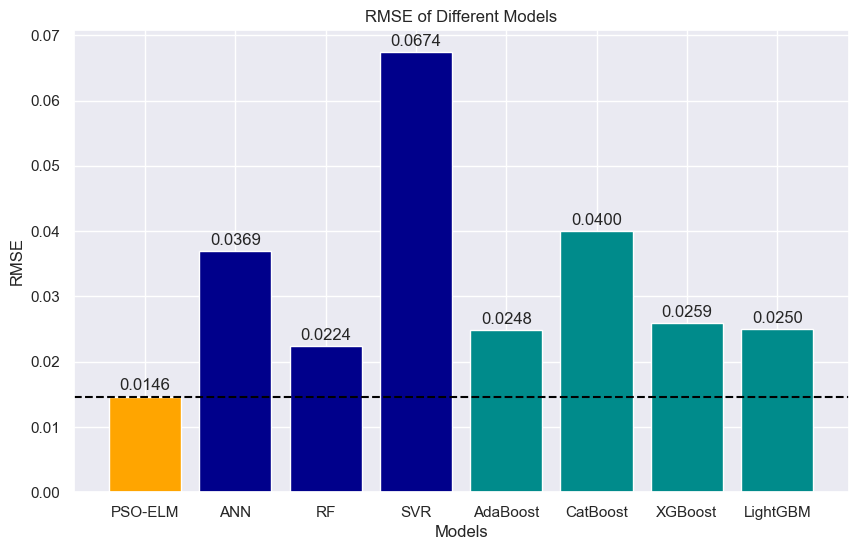

In [6]:
movies={
    "PSO-ELM":0.0146,
    "ANN":0.0369,
    "RF":0.0224,
    "SVR":0.0674,
    "AdaBoost":0.0248,
    "CatBoost":0.0400,
    "XGBoost":0.0259,
    "LightGBM":0.0250
}

#为movies绘制彩色柱状图，并在每个柱体上方显示值
plt.figure(figsize=(10,6))
plt.bar(movies.keys(), movies.values(), color=['orange','darkblue','darkblue','darkblue','darkcyan','darkcyan','darkcyan','darkcyan'])
for x,y in enumerate(movies.values()):
    plt.text(x,y+0.001,'%.4f'%y,ha='center')
plt.title('RMSE of Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
#在y=0.0146处绘制一条平行于x轴的黑色虚线
plt.axhline(y=0.0146,ls='--',c='black')
plt.show()


## 数据分析

数据导入


In [7]:
df = pd.read_pickle('./datasets/data3.8/B0006.pkl')
df

type  ambient_temperature         time  \
0       charge                   24        0.000   
1    discharge                   24     8243.672   
2       charge                   24    12574.063   
3    discharge                   24    23730.485   
4       charge                   24    28042.891   
..         ...                  ...          ...   
611  discharge                   24  4761863.438   
612     charge                   24  4769141.844   
613  discharge                   24  4779444.204   
614  impedance                   24  4782370.719   
615     charge                   24  4831284.125   

                                                  data  
0    {'Voltage_measured': [3.864623580255829, 3.469...  
1    {'Voltage_measured': [4.179799607333447, 4.179...  
2    {'Voltage_measured': [3.2091899557926626, 2.88...  
3    {'Voltage_measured': [4.177288238505559, 4.176...  
4    {'Voltage_measured': [3.2191257818685703, 2.90...  
..                                                 ...  
611  {'Voltage_measured': [4.157544974448367, 4.157...  
612  {'Voltage_measured': [3.731992781674286, 3.314...  
613  {'Voltage_measured': [4.188511527828155, 4.188...  
614  {'Sense_current': [(836.984619140625-28.643907...  
615  {'Voltage_measured': [0.9796499614355424, -0.0...  

[616 rows x 4 columns]

In [8]:
# Print number of records (rows) and columns in the dataframe
print("Number of records:", len(df.index))
print("Number of columns:", len(df.columns))
print("---------------------")

# Printing the data type of each variable
print("Datatype of each column")
df.dtypes

Number of records: 616
Number of columns: 4
---------------------
Datatype of each column


type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object

In [9]:
df[['type', 'ambient_temperature', 'time']].isna().sum()

type                   0
ambient_temperature    0
time                   0
dtype: int64

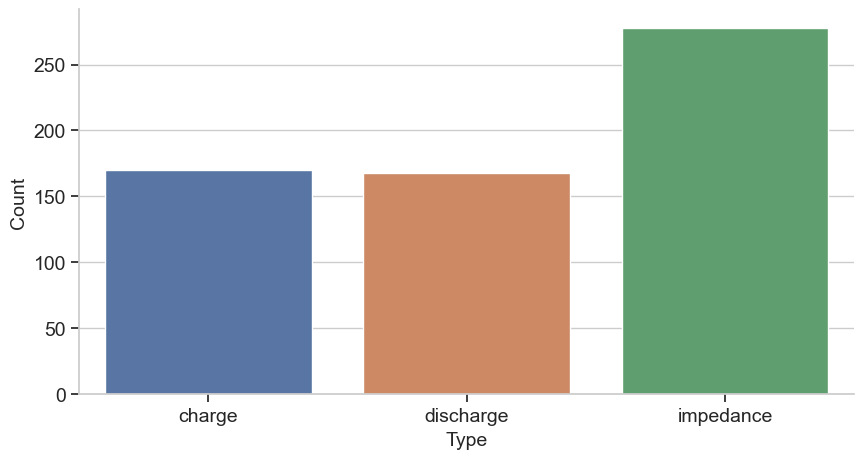

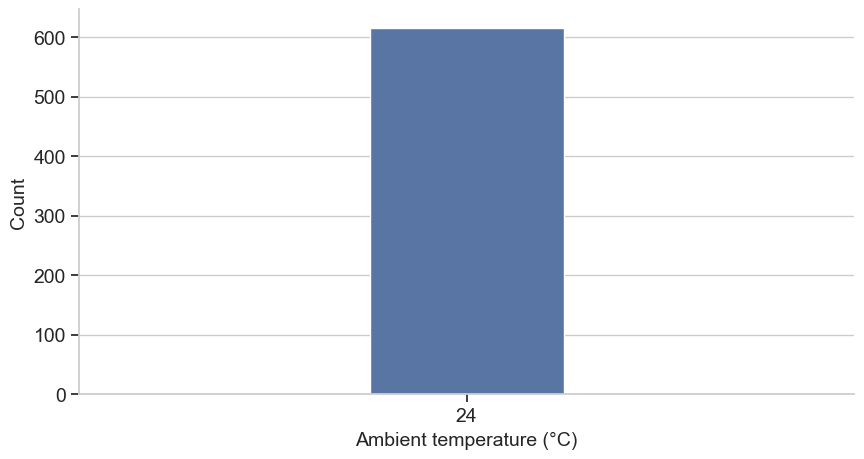

In [10]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
# Function to make a histogram plot for different columns in the data
def change_width(ax, new_value):

    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Changing the bar width
        patch.set_width(new_value)

        # Recentering the bar
        patch.set_x(patch.get_x() + diff * .5)

def plot_histogram(df, col, width = 0):

    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data = df, x = col, dodge = False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    # Change axis labels
    plt.ylabel('Count', fontsize=14)
    if col == 'ambient_temperature': plt.xlabel(col.capitalize().replace('_', ' ') + ' (°C)', fontsize=14)
    else: plt.xlabel(col.capitalize(), fontsize=14)
    # Change tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if width != 0: change_width(ax, width)
    plt.show()

plot_histogram(df=df, col='type')
plot_histogram(df=df, col='ambient_temperature', width = 0.25)

In [11]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('./datasets/data3.8/B00' + num + '.pkl')
    #df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [12]:
charge, discharge, impedance = split_data(cell_number = 6)

### 充电阶段


In [13]:
# This function returns a dataframe containing the measurements and 
# the corresponding datatype stored depending on the "level". 

def get_dtypes(df, col2, level = 1, exclusions = []):
    '''
    查看dataframe中的数据类型

    Arguments:
    df -- pandas DataFrame object
    col2 -- string, label of a columns in the df dataframe
    level -- 整形，level 返回datatype，反之返回dataframe作为数组中对象的类型
    exclusions -- list, if level is not 1, the function will treat the data in the 
                  column as arrays. This exclusions list will contain those rows
                  which have non-array entitities so that a level 2 analysis is
                  skipped for them. (These row labels are obtained after running
                  a level 1 analysis)
    
    Returns:
    pandas DataFrame object 返回列名和对应的数据类型
    '''
    col1 = 'Measurements'
    dtypes = []
    keys = []
    if level == 1: 
        for key in df.iloc[0]['data'].keys(): 
            keys.append(key)
            dtypes.append(str(type(df.iloc[0]['data'][key])))
    else:
        for key in df.iloc[0]['data'].keys(): 
            if not (key in exclusions):
                keys.append(key)
                dtypes.append(df.iloc[0]['data'][key].dtype)

    return pd.DataFrame((keys, dtypes), index = [col1, 'Datatype']).transpose()  

In [14]:
charge.iloc[0]

type                                                              charge
ambient_temperature                                                   24
time                                                                   0
data                   {'Voltage_measured': [3.864623580255829, 3.469...
Name: 0, dtype: object

In [15]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(charge, 'Datatype', level = 1)

Measurements made with the type of data stored in it:


Measurements                 Datatype
0      Voltage_measured  <class 'numpy.ndarray'>
1      Current_measured  <class 'numpy.ndarray'>
2  Temperature_measured  <class 'numpy.ndarray'>
3        Current_charge  <class 'numpy.ndarray'>
4        Voltage_charge  <class 'numpy.ndarray'>
5                  Time  <class 'numpy.ndarray'>

In [16]:
# All the data is in numpy arrays so we also print the datatype
get_dtypes(charge, 'Datatype', level = 2)

Measurements Datatype
0      Voltage_measured  float64
1      Current_measured  float64
2  Temperature_measured  float64
3        Current_charge  float64
4        Voltage_charge  float64
5                  Time  float64

观察到每个字典值都是一个 Python 列表，由数据类型浮点的时间序列数据组成。时间给出了进行测量的时刻。


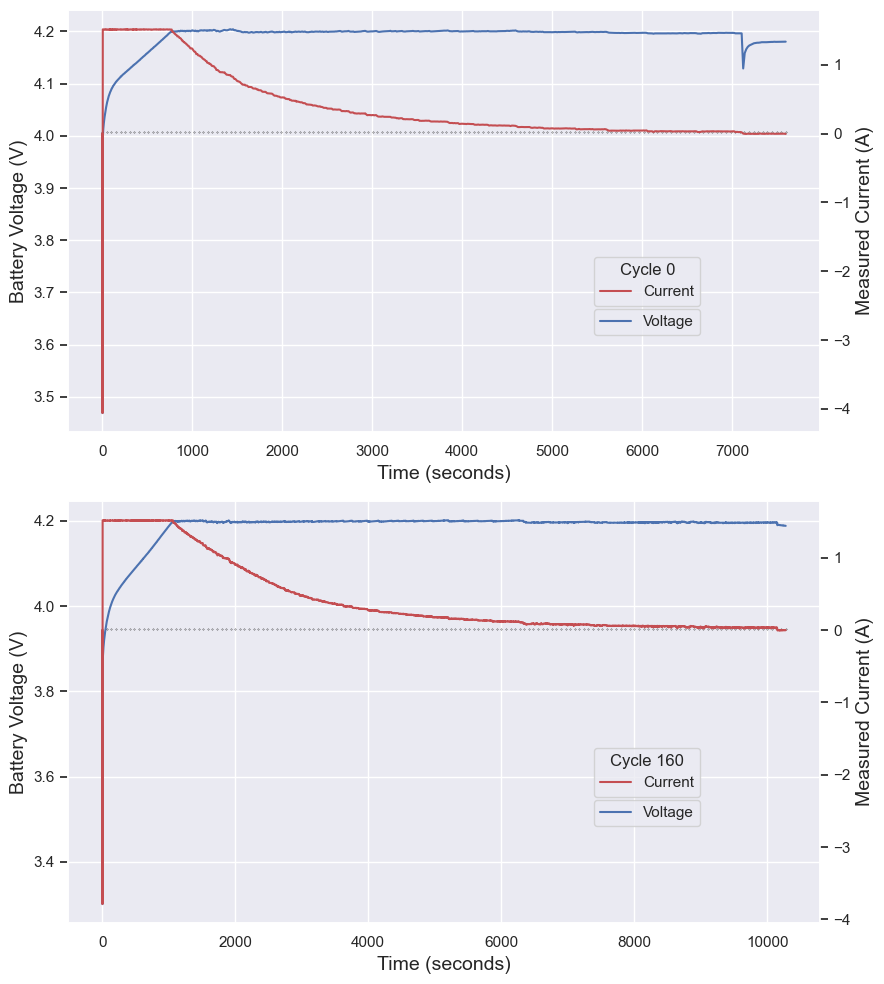

In [17]:
sns.set()
# Plot voltage and current variation for the charging cycle
time0 = charge.iloc[0]['data']['Time'] # Measurement time samples for each run
voltage0 = charge.iloc[0]['data']['Voltage_measured']
current0 = charge.iloc[0]['data']['Current_measured']

time160 = charge.iloc[160]['data']['Time'] # Measurement time samples for each run
voltage160 = charge.iloc[160]['data']['Voltage_measured']
current160 = charge.iloc[160]['data']['Current_measured']

voltages = {0: voltage0, 1: voltage160}
currents = {0: current0, 1: current160}
times = {0: time0, 1: time160}
cycles = {0: 0, 1: 160}

fig, axes = plt.subplots(2, 1, figsize=(9, 10))
axes_2 = [0,0]

for i in [0,1]:
    axes[i].set_xlabel('Time (seconds)', fontsize=14)
    axes[i].set_ylabel('Battery Voltage (V)', fontsize=14)
    axes[i].plot(times[i], voltages[i], label = 'Voltage')
    #axes[i].scatter(times[i], voltages[i], s = 4)
    axes[i].legend(loc = (0.7,0.23))

    axes_2[i] = axes[i].twinx()
    axes_2[i].set_ylabel('Measured Current (A)', fontsize=14)
    axes_2[i].plot(times[i], currents[i], label = 'Current', color = 'r')
    #axes_2[i].scatter(times[i], currents[i], s = 4, color = 'r')
    axes_2[i].grid(False)
    axes_2[i].scatter(np.linspace(0,times[i][-1],150), [0.02 for i in range(150)], s = 0.05, color = 'black')
    axes_2[i].legend(title = f'Cycle {cycles[i]}', loc = (0.7,0.3))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [18]:
axes_2[0]

<AxesSubplot:label='4a98fe34-8494-4242-b699-715853c12e2d', ylabel='Measured Current (A)'>

比较不同周期之间的曲线，我们观察到电池在退化时需要更长的充电时间，这由电池电压达到 4.2V 的时间更长表示。

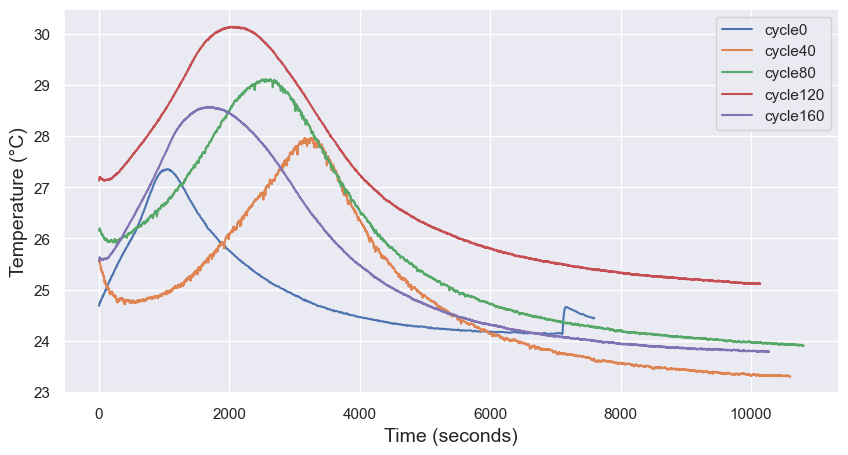

In [19]:
# Temperature variation during charging cycle
plt.figure(figsize=(10, 5))

cycles = [0, 40, 80, 120, 160]
for cycle in cycles:
  time = charge.iloc[cycle]['data']['Time']
  data = charge.iloc[cycle]['data']['Temperature_measured']

  plt.plot(time, data, label=f'cycle{cycle}', linewidth=1.5)
  plt.xlabel('Time (seconds)', fontsize=14)
  plt.ylabel('Temperature (°C)', fontsize=14)

plt.legend()
plt.show()

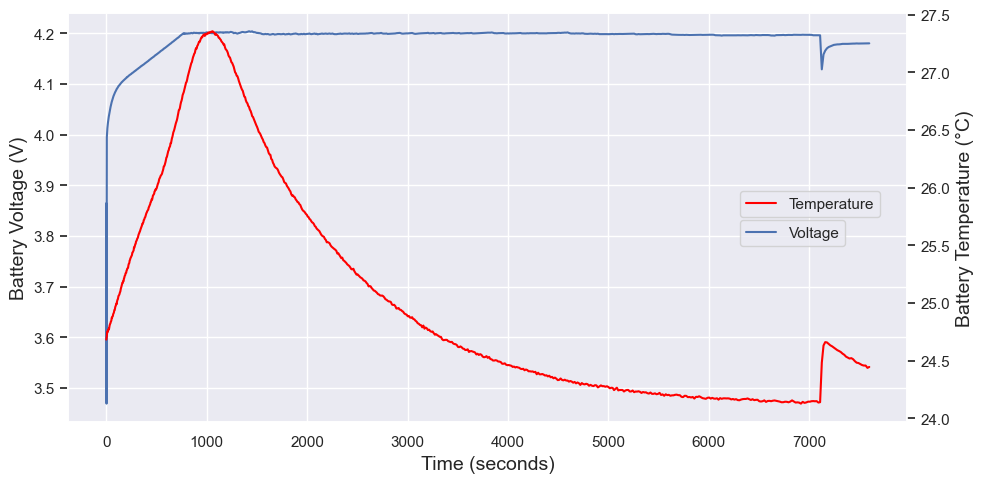

In [20]:
# Plotting temperature and discharge on the same plot
measured_voltage = charge.iloc[0]['data']['Voltage_measured']
measured_temperature = charge.iloc[0]['data']['Temperature_measured']
time = charge.iloc[0]['data']['Time']

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Battery Voltage (V)', fontsize=14)
ax1.plot(time, measured_voltage, label='Voltage')
#ax1.scatter(time, measured_voltage, s=5)
ax1.legend(loc = (0.8,0.43))

ax2 = ax1.twinx() 

ax2.set_ylabel('Battery Temperature (°C)', fontsize=14)
ax2.plot(time, measured_temperature, color='red', label='Temperature')
#ax2.scatter(time, measured_temperature, color='red', s=5)
ax2.legend(loc = (0.8,0.5))
ax2.grid(False)

fig.tight_layout() 
plt.show()

充电周期中的温度与电池退化之间似乎没有很强的相关性

### 阻抗阶段


In [21]:
print(blue('Measurements made with the type of data stored in it:', 'bold'))

get_dtypes(impedance, 'Type', level = 1)

Measurements made with the type of data stored in it:


Measurements                 Datatype
0        Sense_current  <class 'numpy.ndarray'>
1      Battery_current  <class 'numpy.ndarray'>
2        Current_ratio  <class 'numpy.ndarray'>
3    Battery_impedance  <class 'numpy.ndarray'>
4  Rectified_Impedance  <class 'numpy.ndarray'>
5                   Re          <class 'float'>
6                  Rct          <class 'float'>

Sense_current_、_Battery_current、Current_ratio_、_Battery_impedance_Rectified_Impedance_是numpy，而Re（电解电阻）、Rct（电荷转移电阻）是浮点值。numpy 数组的数据类型是复数。

In [22]:
get_dtypes(impedance, 'Datatype', level = 2, exclusions = ['Re', 'Rct'])

Measurements    Datatype
0        Sense_current  complex128
1      Battery_current  complex128
2        Current_ratio  complex128
3    Battery_impedance  complex128
4  Rectified_Impedance  complex128

In [23]:
# Helper function for plotting impedance characteristics
def plot_impedance_characteristics(df, feature, runs=[0, 80, 160, 240], log_scale=False):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    if log_scale:
        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[1].set_xscale('log')
    # Plotting the magnitude for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_magnitude = np.abs(data)[5:]

        axes[0].plot(data_magnitude, label=f'run{run}')
        axes[0].legend()

    axes[0].set_title(f'{feature.replace("_", " ").title()} Magnitude plot', fontsize=16)

    # Plotting the phase for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_phase = [cmath.phase(data[i]) for i in range(len(data))][5:]

        axes[1].plot(data_phase, label=f'run{run}')
        axes[1].legend()

    axes[1].set_title(f'{feature.replace("_", " ").title()} Phase plot', fontsize=16)
    plt.show()

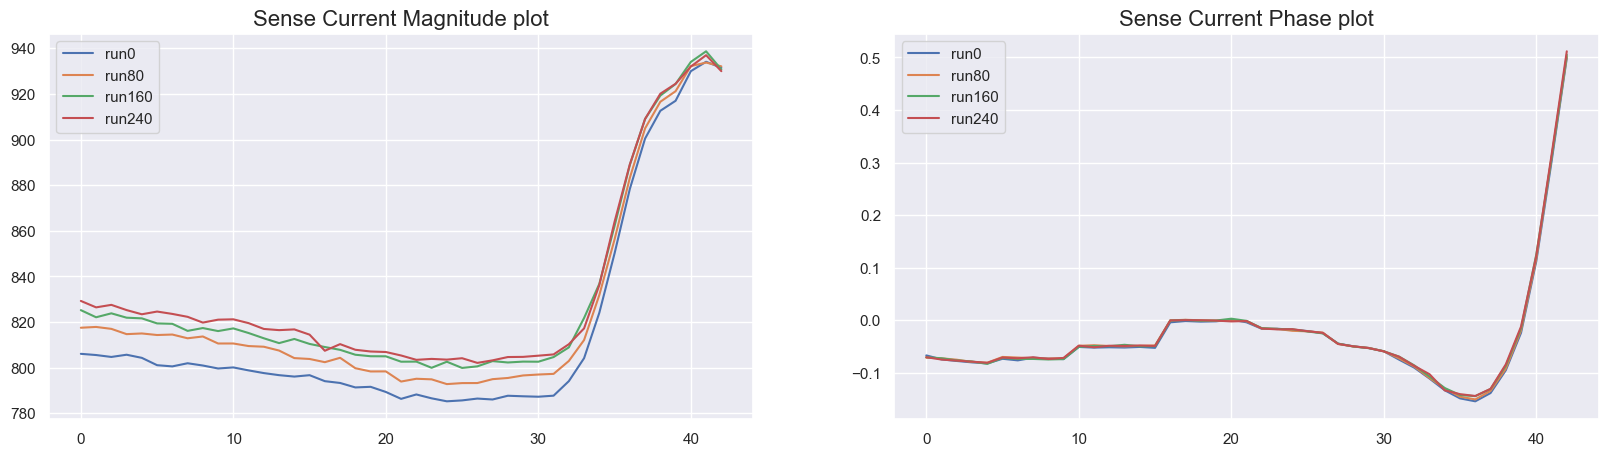

In [24]:
plot_impedance_characteristics(impedance, 'Sense_current')

在不同频率下的电流幅度在不同的运行中几乎是恒定的

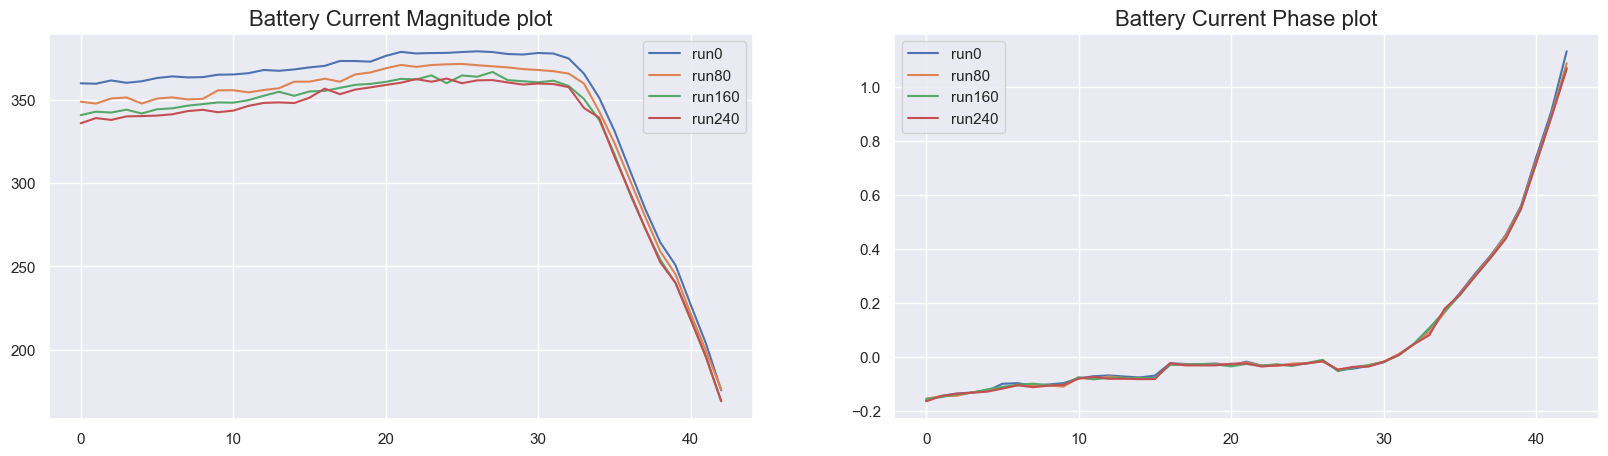

In [25]:
plot_impedance_characteristics(impedance, 'Battery_current')

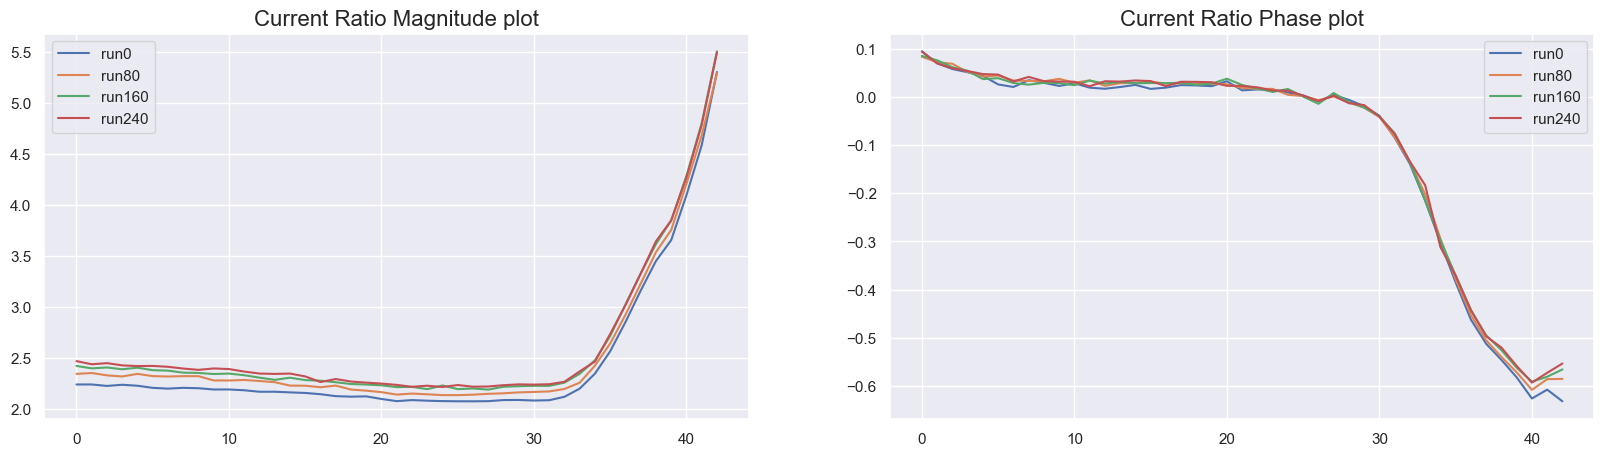

In [26]:
plot_impedance_characteristics(impedance, 'Current_ratio')

电池内部参数似乎没有任何明显的趋势

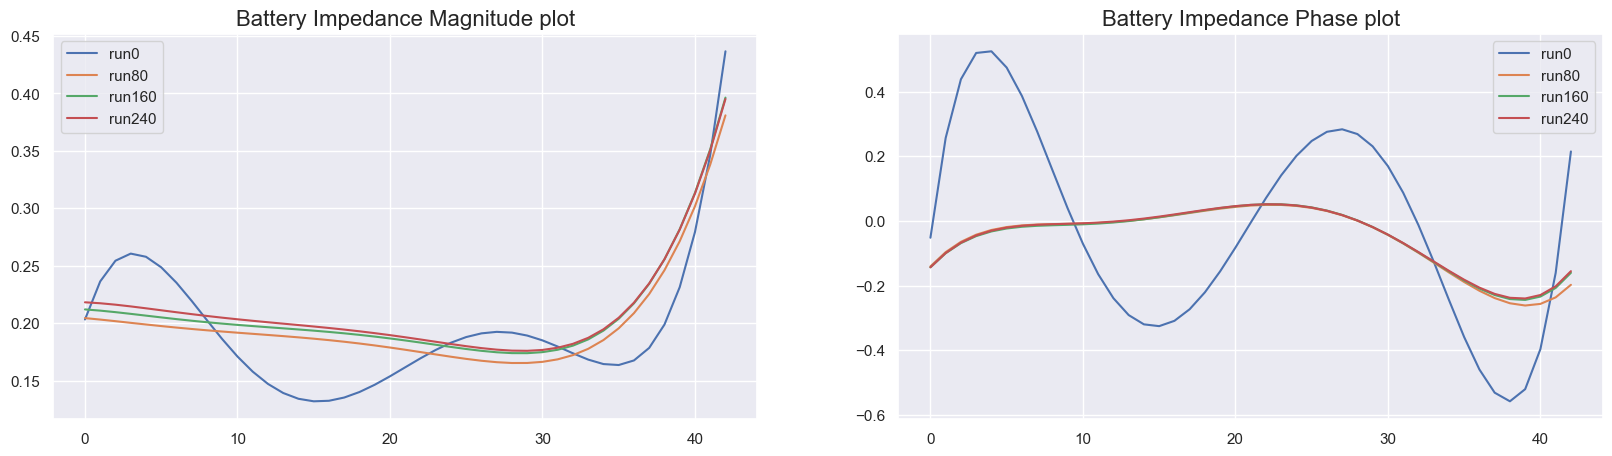

In [27]:
plot_impedance_characteristics(impedance, 'Battery_impedance')

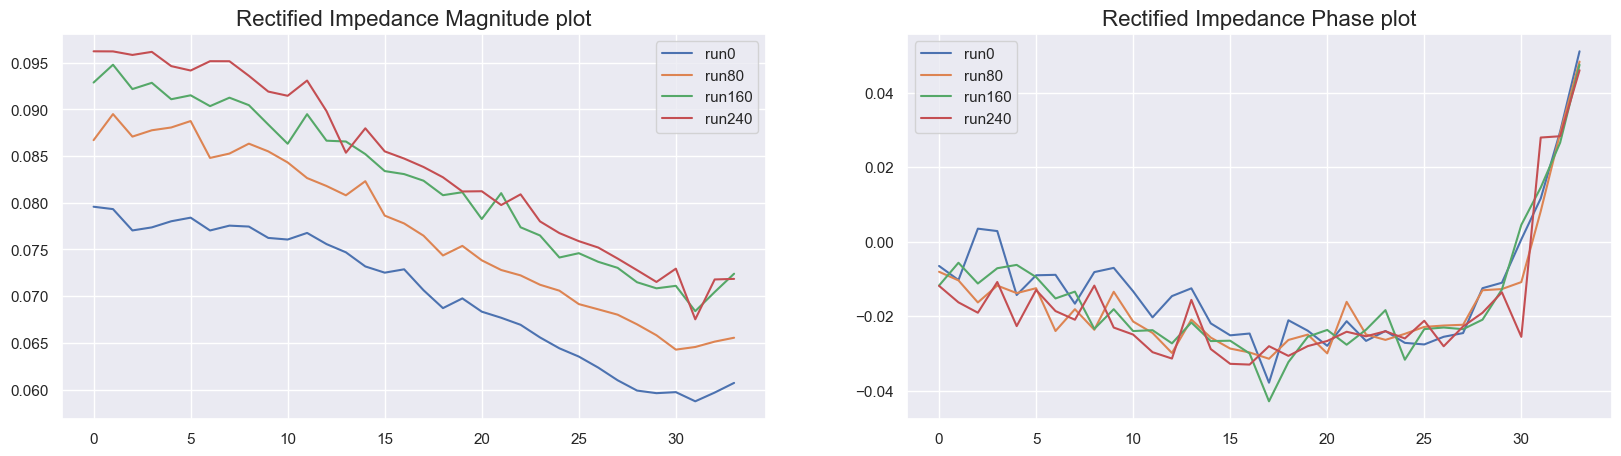

In [28]:
plot_impedance_characteristics(impedance, 'Rectified_Impedance')

幅度图显示随着电池劣化，整流阻抗增加

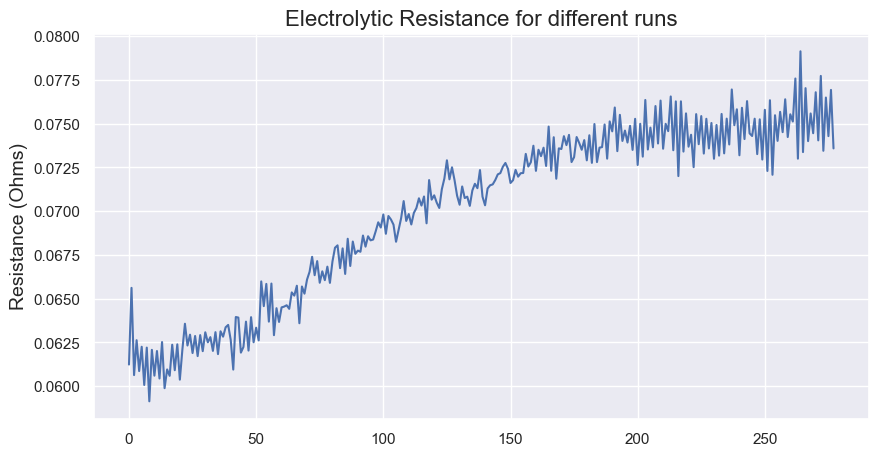

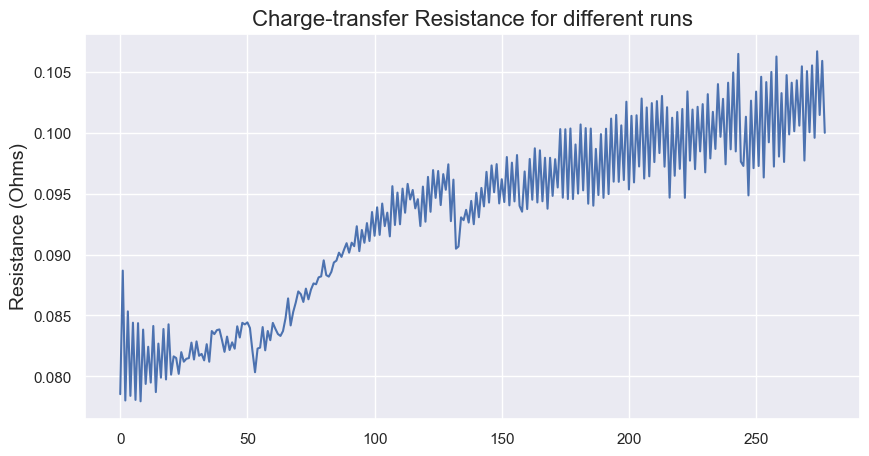

In [29]:
# Helper function to plot resistances as a function of runs
def plot_resistance(df, key):

    resistance = [impedance.iloc[i]['data'][key] for i in range(len(impedance))]

    labels = {
        'Re': 'Electrolytic Resistance',
        'Rct': 'Charge-transfer Resistance'
    }

    plt.figure(figsize=(10, 5))
    plt.title(f'{labels[key]} for different runs', fontsize=16)
    plt.ylabel('Resistance (Ohms)', fontsize=14)
    plt.plot(resistance)

    plt.show()

# Plot the electrolytic and charge-transfer resistance for different runs
plot_resistance(impedance, 'Re')
plot_resistance(impedance, 'Rct')

In [30]:
impedance.index # Print indices for impedance measurements in the original data

Int64Index([ 40,  42,  44,  46,  48,  50,  52,  54,  56,  58,
            ...
            594, 596, 598, 600, 602, 604, 606, 608, 610, 614],
           dtype='int64', length=278)

In [31]:
df[35:50]

type  ambient_temperature         time  \
35     charge                   24   268433.610   
36  discharge                   24   279067.297   
37     charge                   24   283098.204   
38  discharge                   24   293897.563   
39     charge                   24  1398364.969   
40  impedance                   24  1410431.938   
41  discharge                   24  1411321.875   
42  impedance                   24  1416658.391   
43     charge                   24  1417540.422   
44  impedance                   24  1429569.094   
45  discharge                   24  1430451.079   
46  impedance                   24  1435746.266   
47     charge                   24  1436628.422   
48  impedance                   24  1448655.735   
49  discharge                   24  1449537.782   

                                                 data  
35  {'Voltage_measured': [3.4129792185793604, 3.09...  
36  {'Voltage_measured': [4.176354539745044, 4.176...  
37  {'Voltage_measured': [3.4074542037134967, 3.09...  
38  {'Voltage_measured': [4.177126477703333, 4.177...  
39  {'Voltage_measured': [3.6565665959743034, 3.29...  
40  {'Sense_current': [(641.7734375-13.88265800476...  
41  {'Voltage_measured': [4.174584178175673, 4.174...  
42  {'Sense_current': [(-1+1j), (834.7174072265625...  
43  {'Voltage_measured': [3.2909501222137076, 2.96...  
44  {'Sense_current': [(649.273681640625-23.115520...  
45  {'Voltage_measured': [4.175224020262452, 4.175...  
46  {'Sense_current': [(-1+1j), (851.6993408203125...  
47  {'Voltage_measured': [3.3671940478328177, 3.03...  
48  {'Sense_current': [(679.4708862304688-24.89230...  
49  {'Voltage_measured': [4.177217300859919, 4.177...

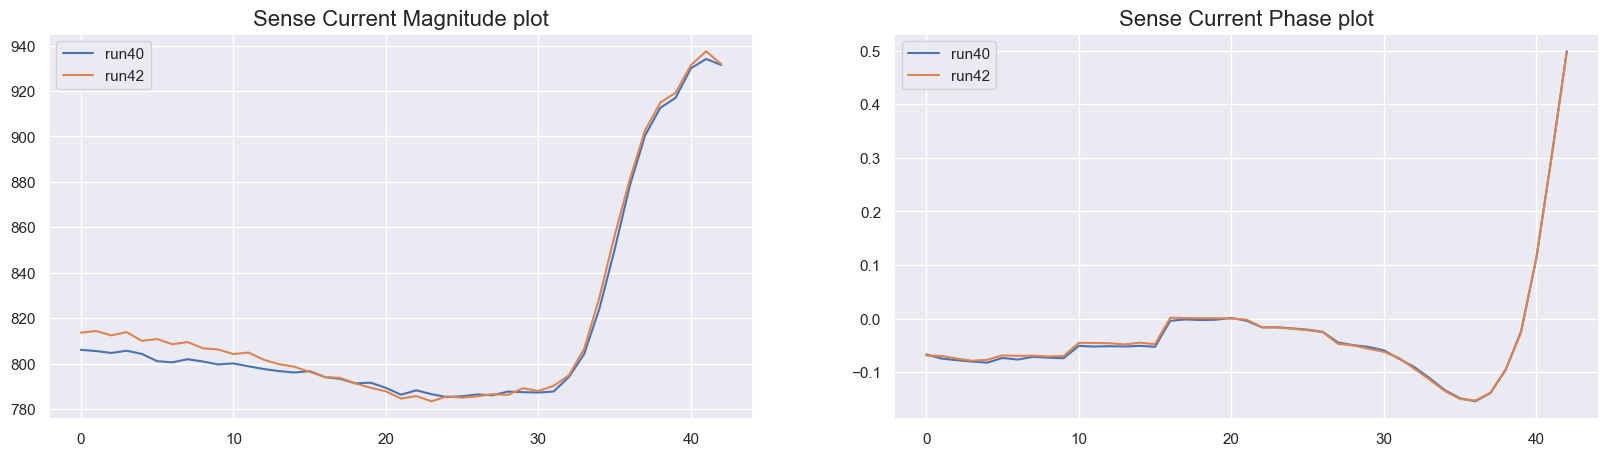

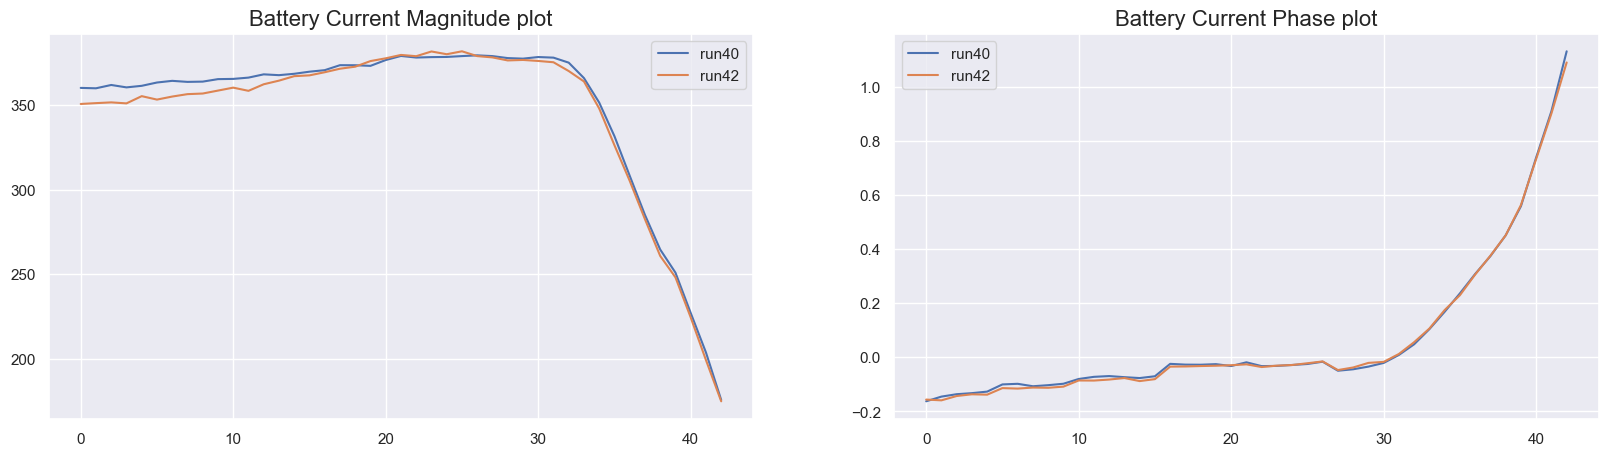

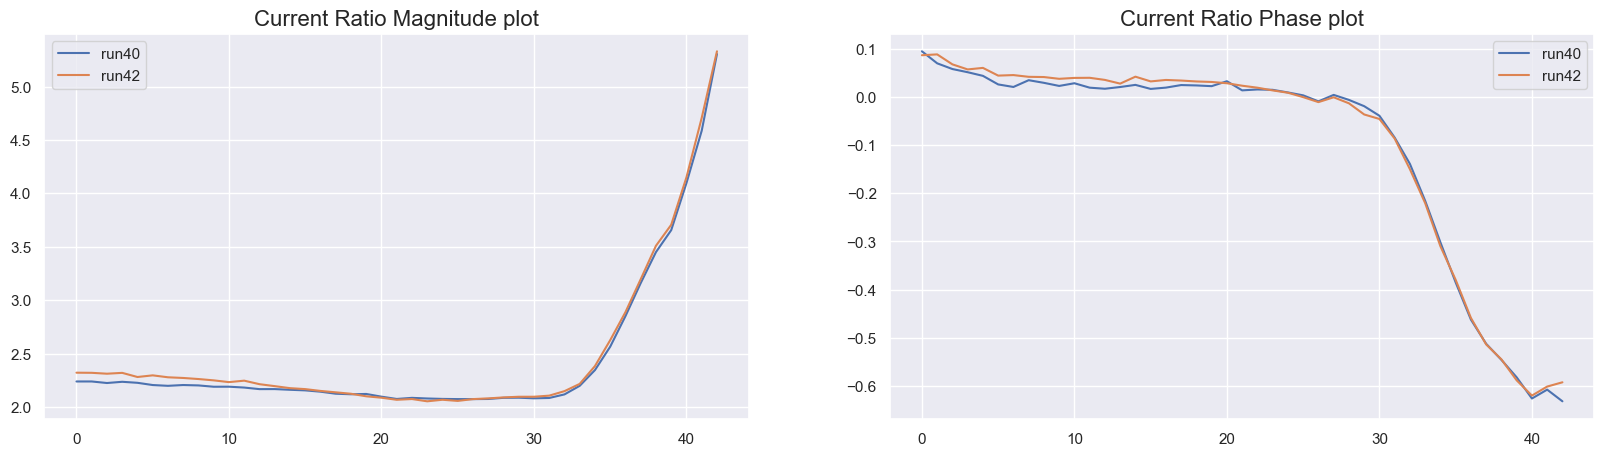

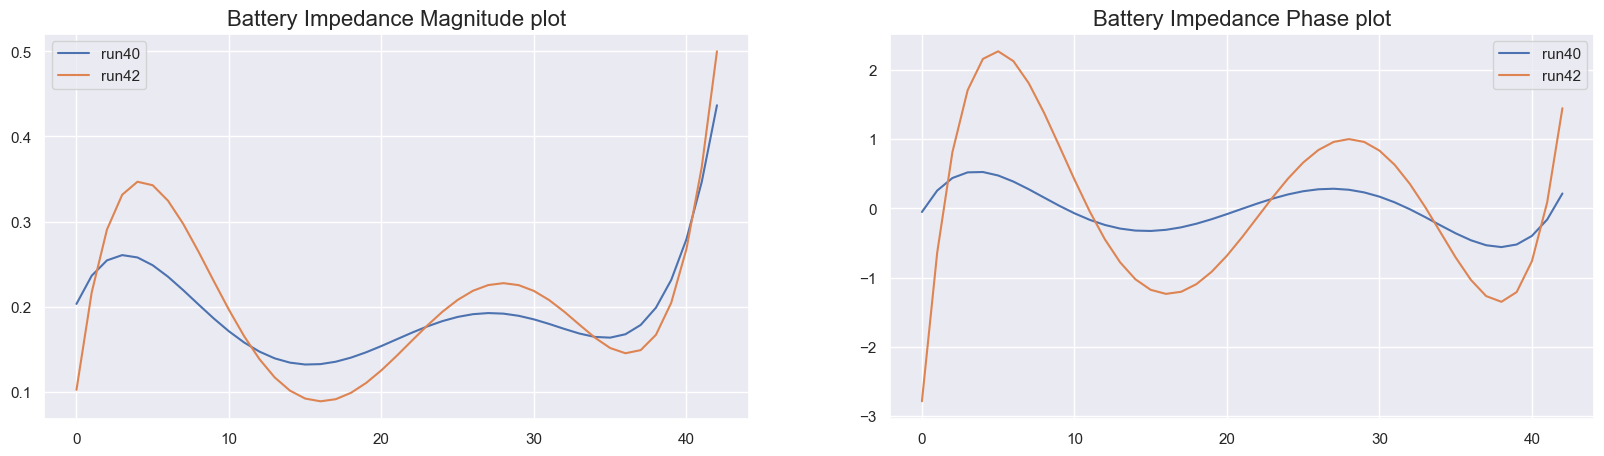

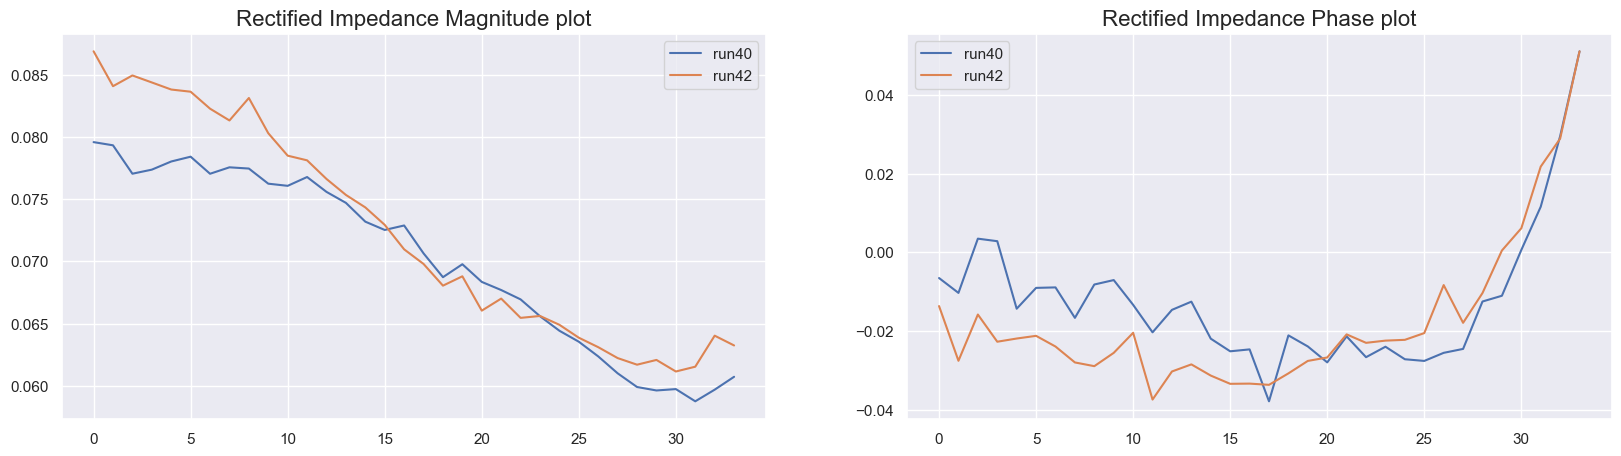

In [32]:
# 40 is an impedance measurement after charging
# 42 is an impedance measurement after discharging
runs = [40, 42] 
keys = ['Sense_current', 'Battery_current', 'Current_ratio', 
        'Battery_impedance', 'Rectified_Impedance']
for key in keys:
  plot_impedance_characteristics(df, key, runs, log_scale=False) # Plotting the parameters in keys

**Nyquist plots**

In [33]:
def plot_nyquist(df, feature, runs=[0, 80, 160, 240]):

    plt.figure(figsize=(10, 5))
    # Plotting the magnitude for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_real = [data[i].real for i in range(len(data))]
        data_imag = [-data[i].imag for i in range(len(data))]

        plt.scatter(data_real, data_imag, label=f'run{run}')
        plt.legend()

    plt.title(f'{feature.replace("_", " ").title()} Nyquist plot', fontsize=16)
    plt.xlabel('Re(Z) Ω', fontsize=14)
    plt.ylabel('-Im(Z) Ω', fontsize=14)
    plt.show()

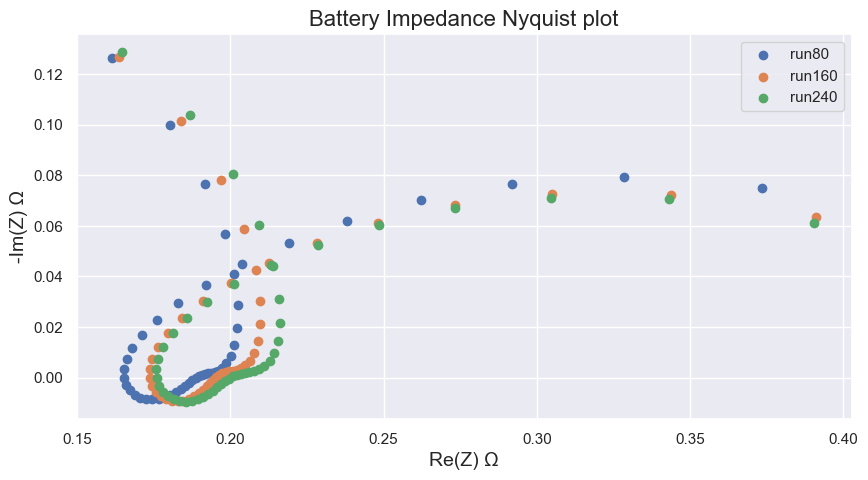

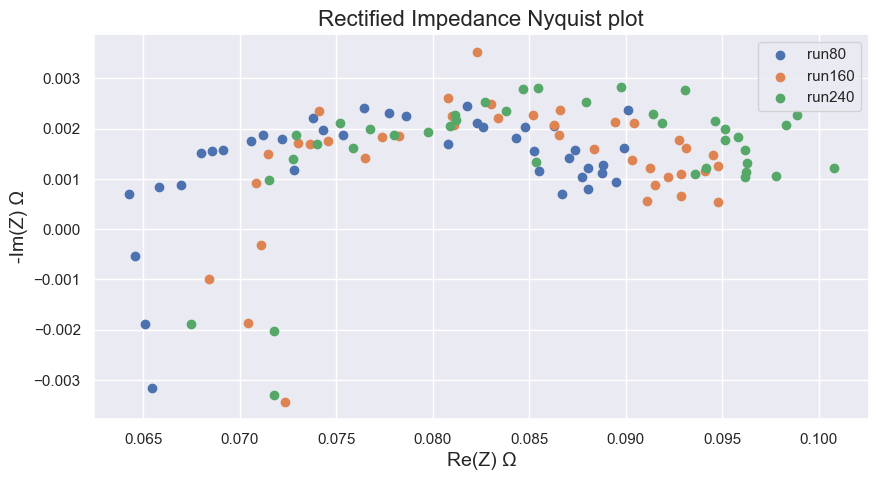

In [34]:
plot_nyquist(impedance, feature='Battery_impedance', runs=[80, 160, 240]) # Plotting the parameters in keys
plot_nyquist(impedance, feature='Rectified_Impedance', runs=[80, 160, 240]) # Plotting the parameters in keys

电池电阻似乎在放电时增加。

### 放电阶段

In [35]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(discharge, 'Datatype', level = 1)

Measurements made with the type of data stored in it:


Measurements                 Datatype
0      Voltage_measured  <class 'numpy.ndarray'>
1      Current_measured  <class 'numpy.ndarray'>
2  Temperature_measured  <class 'numpy.ndarray'>
3          Current_load  <class 'numpy.ndarray'>
4          Voltage_load  <class 'numpy.ndarray'>
5                  Time  <class 'numpy.ndarray'>
6              Capacity          <class 'float'>

除容量外，所有要素都是时间序列数据

In [36]:
# Printing the datatype of each key which is an array.
# Capacity is of type float so it will be excluded
get_dtypes(discharge, 'Datatype', level = 2, exclusions = ['Capacity'])

Measurements Datatype
0      Voltage_measured  float64
1      Current_measured  float64
2  Temperature_measured  float64
3          Current_load  float64
4          Voltage_load  float64
5                  Time  float64

In [37]:
from matplotlib.patches import Rectangle
# This function plots the data of specified type (voltage, current or temperature)
sns.set()
def dc_cycle_plots(cell_number, cycle_list, type, figsize = (10,5), only_scatter = False, zoom_beginning_range = None):

    _, discharge, _= split_data(cell_number)

    labels = {'voltage': 'Battery terminal voltage (V)',
              'current': 'Battery output current (A)',
              'temperature': 'Battery temperature (°C)'}
    type_ = type.capitalize() + '_measured'

    fig, ax0 = plt.subplots(1, 1, figsize = figsize)

    for cycle in cycle_list:
        time_data = discharge.iloc[cycle]['data']['Time']   # List of times obtained from the "discharge" dataframe
        type_data = discharge.iloc[cycle]['data'][type_]
        print(type_data.shape)    # Data of the type specified, obtained from the "discharge" dataframe

        if not only_scatter: ax0.plot(time_data, type_data, label = f"cycle {cycle}")
        ax0.scatter(time_data, type_data, s = 5)

    plt.title(f"{type.capitalize()} Measured for cell number {cell_number}", fontsize = 16)
    plt.xlabel("Time (seconds)", fontsize = 14)
    plt.ylabel(labels[type], fontsize = 14)
    plt.legend()

    if zoom_beginning_range != None and type == 'voltage':
        ax0.add_patch(Rectangle((-50,3.9), 200, 0.4, edgecolor = "black", facecolor = "none"))
        ax0.text(200, 4.1, "Initial Sharp Decrease")
        sns.reset_orig()
        ax = fig.add_axes([0.17, 0.3, 0.2, 0.2])
        for cycle in cycle_list:
            time_data = discharge.iloc[cycle]['data']['Time'][:zoom_beginning_range]   # List of times obtained from the "discharge" dataframe
            type_data = discharge.iloc[cycle]['data'][type_][:zoom_beginning_range]    # Data of the type specified, obtained from the "discharge" dataframe

            ax.plot(time_data, type_data)
            ax.scatter(time_data, type_data, s = 1)
            ax.set_xlabel("Magnified portion")
            ax.grid(False)
        sns.set()

    plt.show()

(197,)
(355,)
(330,)
(315,)
(298,)


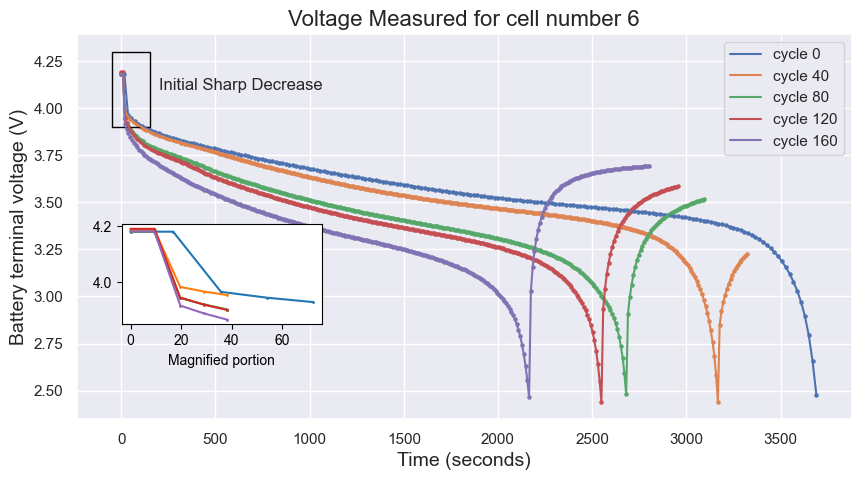

(197,)
(355,)
(330,)
(315,)
(298,)


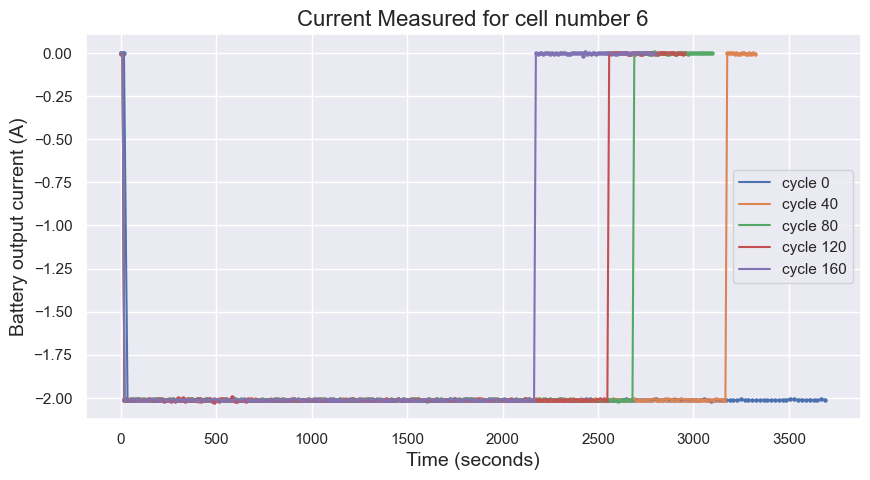

(197,)
(355,)
(330,)
(315,)
(298,)


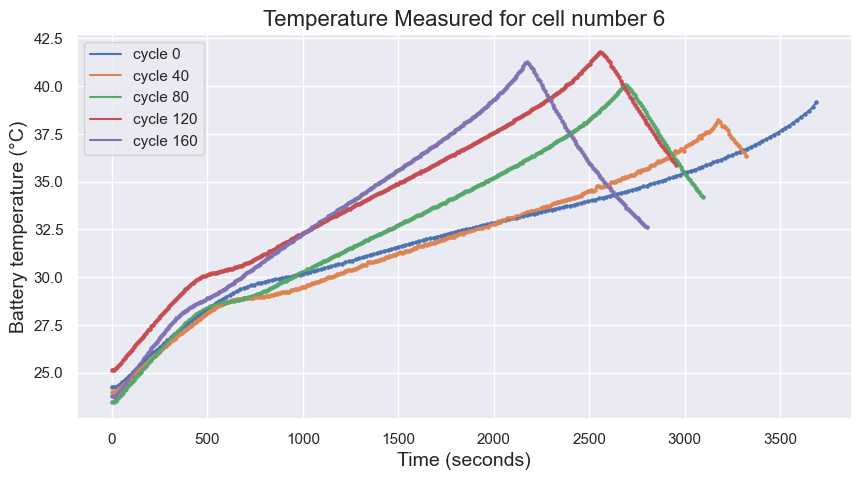

In [38]:
cycles = [0, 40, 80, 120, 160]
figsize = (10,5)

# Observing that voltage has an initial drop, we magnify the initial sharp decrease in voltage measured
dc_cycle_plots(6, cycles, 'voltage', figsize = figsize, only_scatter = False, zoom_beginning_range = 5) 

dc_cycle_plots(6, cycles, 'current', figsize = figsize, only_scatter = False)
dc_cycle_plots(6, cycles, 'temperature', figsize = figsize, only_scatter = False)

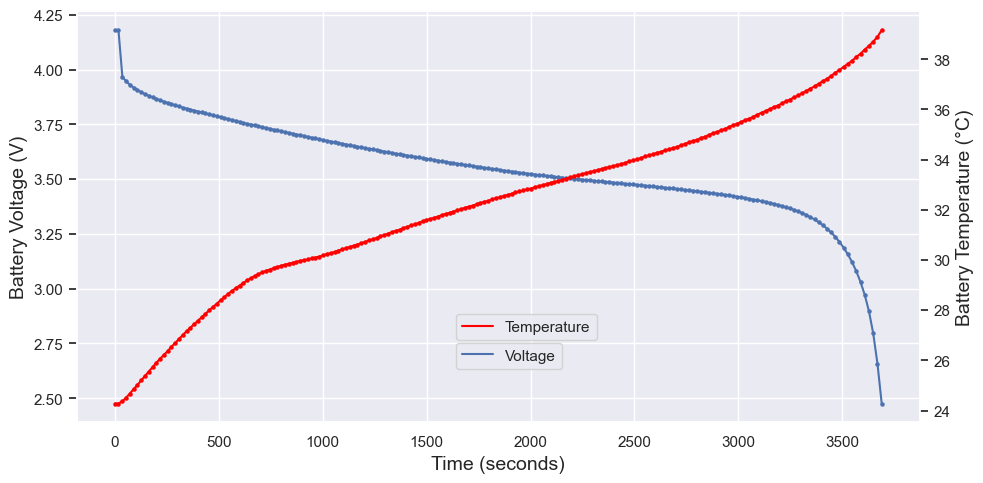

In [39]:
# Plotting temperature and discharge on the same plot
measured_voltage = discharge.iloc[0]['data']['Voltage_measured']
measured_temperature = discharge.iloc[0]['data']['Temperature_measured']
time = discharge.iloc[0]['data']['Time']

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Battery Voltage (V)', fontsize=14)
ax1.plot(time, measured_voltage, label='Voltage')
ax1.scatter(time, measured_voltage, s=5)
ax1.legend(loc = (0.45,0.13))

ax2 = ax1.twinx() 

ax2.set_ylabel('Battery Temperature (°C)', fontsize=14)
ax2.plot(time, measured_temperature, color='red', label='Temperature')
ax2.scatter(time, measured_temperature, color='red', s=5)
ax2.grid(False)
ax2.legend(loc = (0.45,0.2))

fig.tight_layout() 
plt.show()

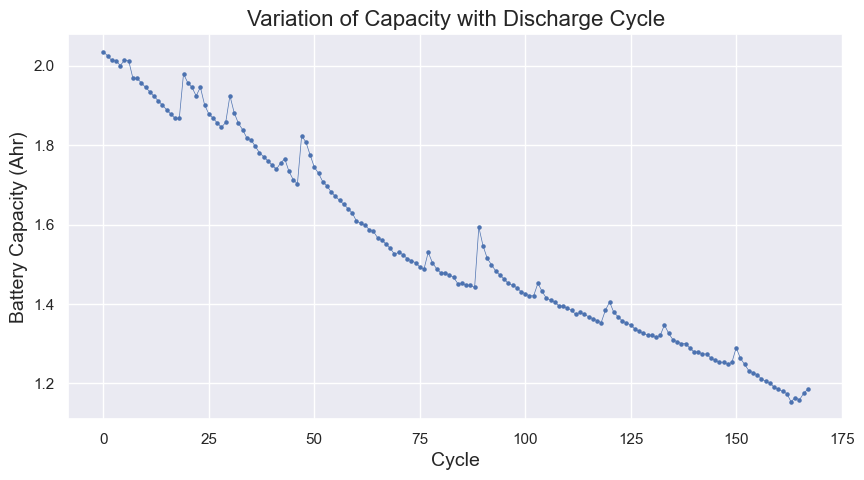

In [40]:
# Plotting capacity as a function of discharge cycles
capacity = [discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))]

plt.figure(figsize=(10, 5))
plt.title('Variation of Capacity with Discharge Cycle', fontsize=16)
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('Battery Capacity (Ahr)', fontsize=14)

plt.plot(capacity, linewidth=0.5)
plt.scatter(np.arange(0, len(capacity)), capacity, s=5)
plt.show()

放电特性中的一些重要特征。

测量电压
可以将图分为 4 个部分：开始急剧下降，这似乎是线性的。随后出现指数状下降，之后实验停止。电池电压在此之后开始上升。

测量温度
我们可以将图分为 3 个部分：陡峭的温度上升，温度上升并降低斜率直到峰值温度，最后下降。

我们观察到，随着电池的劣化，电池放电所需的时间越来越短。我们还观察到，随着电池放电，电池达到的最高温度单调增加。随着电池退化，电池达到最高温度所需的时间更短。
一旦电池电压降至2.6-2.7V，放电就会停止。这是因为 18650 锂离子电池的放电截止电压为 3.0V。该实验推动电池超越了这一点，以加速数据集描述中提到的退化效应。

### 预测 RUL

首先对数据进行预处理以进行特征提取。 提取的特征：

1. 电池电压达到 2.7V 至 4V 之间指定电压值的时间瞬间
2. 电池放电和负载电流停止的时间
3. 电池在放电过程中达到的最高温度
4. 电池达到最高温度的时间


In [41]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    '''
    Takes cell number as input and return three dataframes containing the different types of data in the 
    corresponding .pkl datafile

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18 (.pkl files corresponding to the above mentioned cells are available)

    Returns:
    charge -- pandas DataFrame object, contains the data of type "charge" pulled from the specified .pkl file
    discharge -- pandas DataFrame object, contains data of type "discharge"
    impedance -- pandas DataFrame object, contains data of type "impedance" 
    '''
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('./datasets/data3.8//B00' + num + '.pkl')

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [42]:
# This function performs the major preprocessing of the data, by picking out the data values 
# which will be used for training out of the complete available data
def preprocessing(cell_number, voltage_splits = 16):
    '''
    Extracts features and labels from the data from the specified cell number 
    and returns them as numpy arrays

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18
    voltage_splits -- integer, specifies number of values the interval of voltages
                      [2.7, 4] should be split into
    
    Returns:
    x -- numpy array, contains the feature data. The required features are extracted
         from the discharge data of the specified cell number.
    y -- numpy array, contains the labels corresponding to the features in "x"
    '''
    _, discharge, _ = split_data(cell_number)

    # Default split is 16 which gives the following voltages:
    # [2.7, 2.787, 2.873, 2.96, 3.047,3.13333333, 3.22, 3.307, 3.393, 
    # 3.48, 3.567, 3.653, 3.74, 3.827, 3.913, 4.]
    voltages = np.linspace(2.7, 4, voltage_splits)
    
    # features0 stores the Times at which terminal voltage is 2.7, ..., 4
    # features1 stores the Time to reach minimum terminal voltage
    # feature2 stores the Maximum temperature
    # feature3 stores the Time to reach maximum temperature
    
    feature0, feature1, feature2, feature3 = [], [], [], []
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']                       # Getting time data from the discharge dataframe
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']        # Getting voltage data
        temp_data = discharge.iloc[i]['data']['Temperature_measured']       # Getting temperature data

        times = []
        for j in range(voltage_splits):
            time_for_closest_voltage = time_data[np.argmin(np.abs(voltage_data - voltages[j]))]         # time at which the reading stored in "voltage_data" is closest 
            times.append(time_for_closest_voltage)                                                      # to one of the values in the "voltages" array
        
        feature0 = feature0 + [times]
        feature1.append(time_data[np.argmin(voltage_data)])
        feature2.append(np.max(temp_data))

        time_for_max_temp = time_data[np.argmax(temp_data)]                 # time at which temperature reaches its maximum value
        feature3.append(time_for_max_temp)


    x = np.array(feature0)
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]

    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((x, feature1, feature2, feature3))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])
    
    return x, y

提取的特征并非都是唯一的。它们之间存在高度相关性，这通过使用相关热图来说明

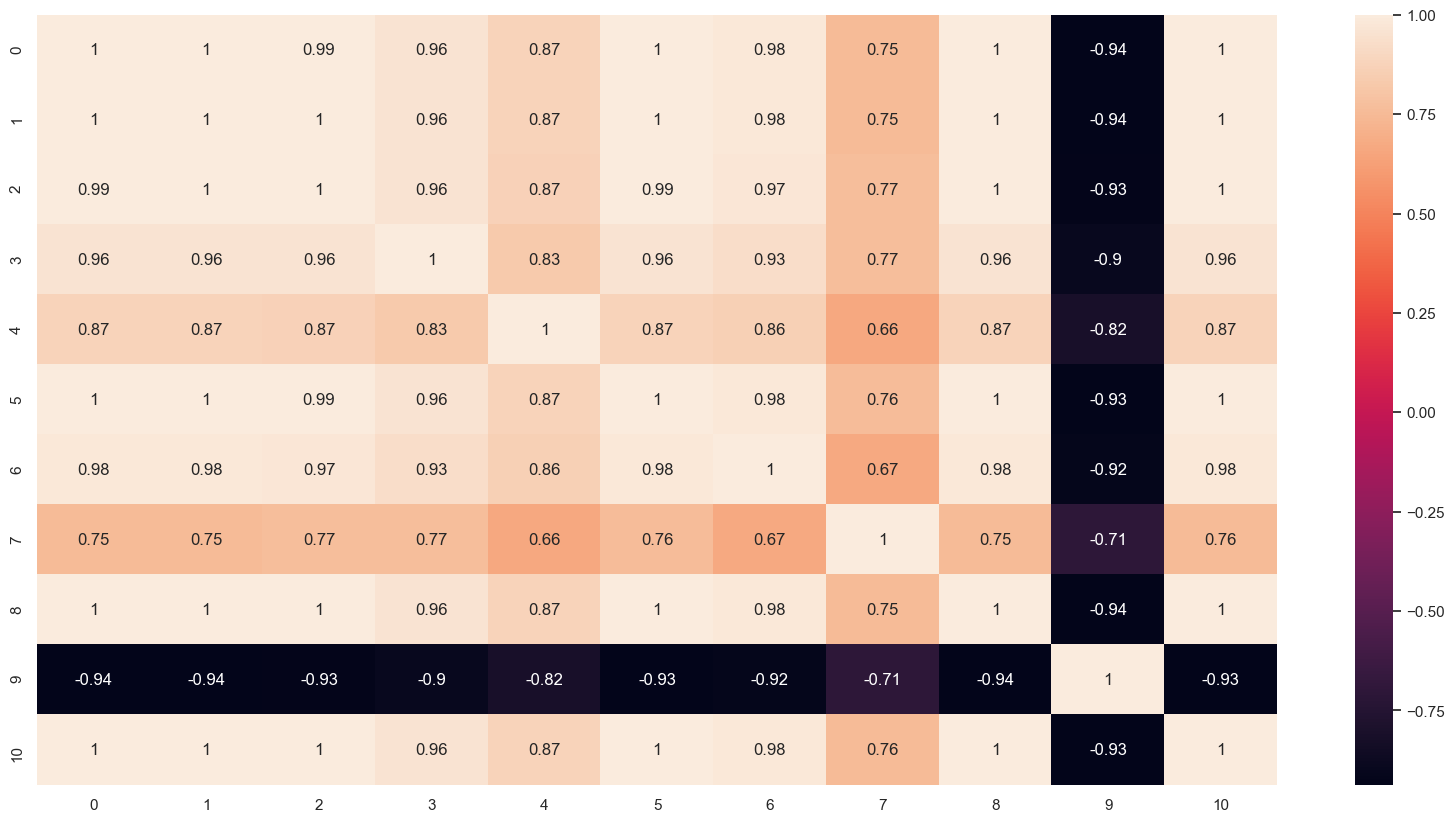

In [43]:
x, y = preprocessing(5, 8)

# Plot a correlation matrix to determine if there are any redundancies
corr = pd.DataFrame(x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, 
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 annot=True)

PearsonRResult(statistic=0.9998371746721278, pvalue=2.2221814507883833e-291)
PearsonRResult(statistic=0.9998679886643883, pvalue=6.097202013618654e-299)
PearsonRResult(statistic=0.9954653434894557, pvalue=1.5489407421309433e-171)
PearsonRResult(statistic=0.959989931431982, pvalue=1.1113884498967833e-93)
PearsonRResult(statistic=0.8729985648085734, pvalue=1.2193807444790076e-53)
PearsonRResult(statistic=0.9984306412933939, pvalue=9.863792408640462e-210)
PearsonRResult(statistic=0.9840593502034656, pvalue=2.0098457517724552e-126)
PearsonRResult(statistic=0.7489326548546136, pvalue=1.7682493550456918e-31)
PearsonRResult(statistic=0.9999474268642141, pvalue=0.0)
PearsonRResult(statistic=-0.9352719475323323, pvalue=8.713478920411383e-77)
PearsonRResult(statistic=0.9998125748671007, pvalue=2.618988289518788e-286)


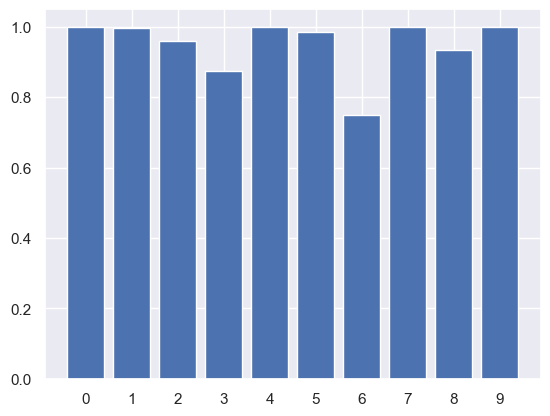

In [44]:
#检验x中的10个特征和y的Pearson相关性
from scipy.stats import pearsonr
for i in range(11):
    print(pearsonr(x[:,i],y))

#将相关度保存到list中
corr_list = []
for i in range(11):
    corr_list.append(pearsonr(x[:,i],y)[0])
#取绝对值
corr_list = [abs(i) for i in corr_list]
#绘制柱状图，柱之间无间隔
plt.figure()
plt.bar(np.arange(10),corr_list[1:])
plt.xticks(np.arange(10))
plt.show()


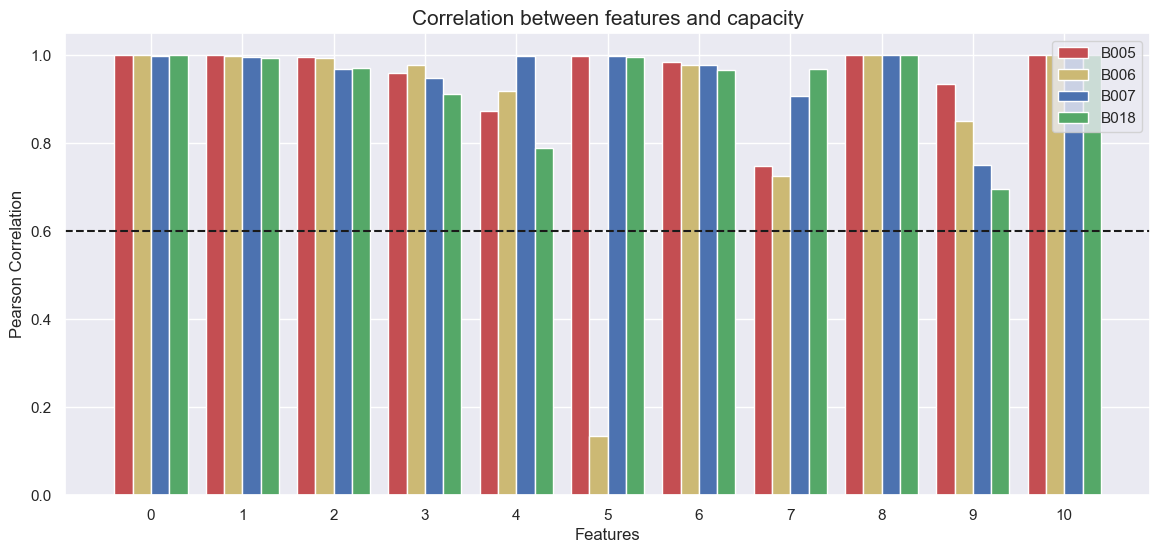

In [45]:
f1,c1=preprocessing(5, 8)
f2,c2=preprocessing(6, 8)
f3,c3=preprocessing(7, 8)
f4,c4=preprocessing(18, 8)
#计算4块电池数据中f与c的peason相关系数，分别存入list中
corr_list1 = []
corr_list2 = []
corr_list3 = []
corr_list4 = []
for i in range(11):
    corr_list1.append(pearsonr(f1[:,i],c1)[0])
    corr_list2.append(pearsonr(f2[:,i],c2)[0])
    corr_list3.append(pearsonr(f3[:,i],c3)[0])
    corr_list4.append(pearsonr(f4[:,i],c4)[0])
#取绝对值
corr_list1 = [abs(i) for i in corr_list1]
corr_list2 = [abs(i) for i in corr_list2]
corr_list3 = [abs(i) for i in corr_list3]
corr_list4 = [abs(i) for i in corr_list4]
#绘制柱状图，,每个特征为一组，每组4个柱，每组无间隔，不同组间有间隔，不同电池颜色不同
plt.figure(figsize=(14,6))
plt.bar(np.arange(11)-0.3,corr_list1[:],width=0.2,color='r',label='B005')
plt.bar(np.arange(11)-0.1,corr_list2[:],width=0.2,color='y',label='B006')
plt.bar(np.arange(11)+0.1,corr_list3[:],width=0.2,color='b',label='B007')
plt.bar(np.arange(11)+0.3,corr_list4[:],width=0.2,color='g',label='B018')
plt.xticks(np.arange(11))
#在0.6绘制横线
plt.axhline(y=0.6,ls='--',c='k')

plt.ylabel('Pearson Correlation')
plt.xlabel('Features')
plt.title('Correlation between features and capacity',size=15)

plt.legend()
plt.show()


In [46]:
#将4个list导出到csv文件中，保留5位小数，每行为一个list
import csv
with open('corr.csv','w',newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['B005','B006','B007','B018'])
    for i in range(11):
        writer.writerow([round(corr_list1[i],5),round(corr_list2[i],5),round(corr_list3[i],5),round(corr_list4[i],5)])



## 机器学习


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [48]:

def prep_for_training(x, y, scale_config = True):
    '''
    准备机器学习数据集，使用StandardScaler标准化
    '''
    global scaler
    
    # Split the data in the ratio 80:20 for training, testing respectively
    train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8)

    if scale_config:
        # Standardize the training data
        scaler = StandardScaler()
        # Fit the scaler to X_train
        scaler.fit(train_x)

    # Transform the entire data using the computed mean and variance
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    train = [train_x, train_y]
    test = [test_x, test_y]
    
    return train, test

PCA，保留1%标准偏差

4 components are sufficient to satisfy the RMSE reconstruction criterion


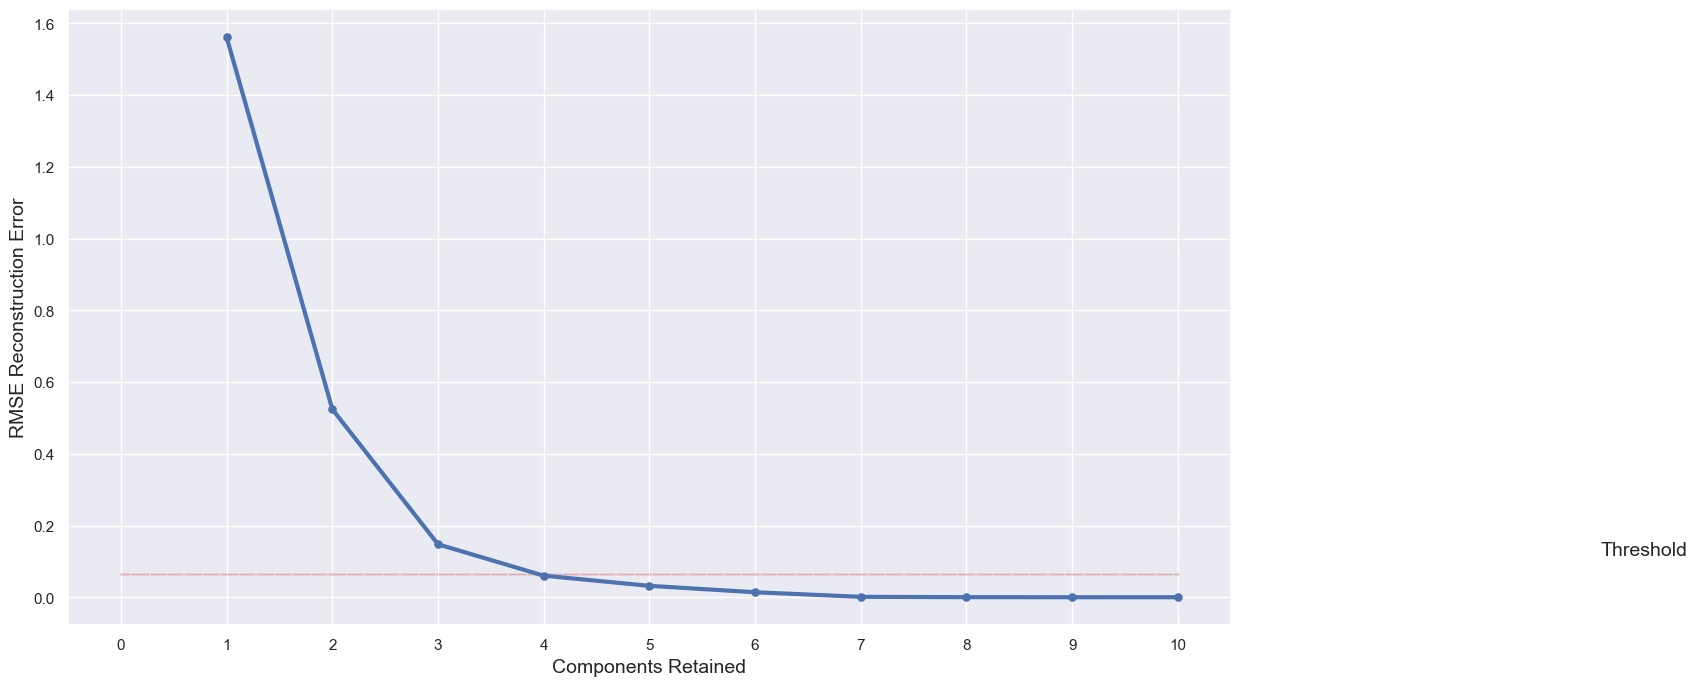

In [49]:
x, y = preprocessing(5, 7)     # using cell 5 for training
[train_x, train_y], [test_x, test_y] = prep_for_training(x, y)

# Import the module for PCA
from sklearn.decomposition import PCA

# Re-centre the data to have zero mean
X_for_pca = train_x - np.mean(train_x, axis=0)[np.newaxis, :]

# Compute std. deviation of L2 norm input vectors
l2_norm = np.sum(X_for_pca ** 2, axis=-1)
std_dev = np.std(l2_norm)

# Threshold for dimensionality reduction set to 1% of std. deviation
threshold = 0.01 * std_dev

rmse_vs_components = []   # List of RMSE vs n_components for plotting
desired_components = 10   # Start by assuming all components are necessary

# Iterate over number of retained dimensions
for n_components in range(1, 11):
    pca = PCA(n_components=n_components)

    # Fit PCA onto the input data
    pca.fit(X_for_pca)

    # Apply dimensionality reduction on X
    X_transformed = pca.transform(X_for_pca)

    # Transform back to the starting space to compute reconstruction error
    X_projected = pca.inverse_transform(X_transformed)

    # Compute RMSE reconstruction error
    rmse = np.sum((X_for_pca - X_projected) ** 2, axis=-1).mean()

    if rmse < threshold:
        desired_components = min(n_components, desired_components)

    rmse_vs_components.append(rmse)

# Plot RMSE vs Components Retained
plt.figure(figsize=(15, 8))
plt.xlabel('Components Retained', fontsize=14)
plt.ylabel('RMSE Reconstruction Error', fontsize=14)
plt.plot(np.arange(1, 11), rmse_vs_components, lw=3)
plt.scatter(np.arange(1, 11), rmse_vs_components, lw=3, s = 10)
plt.scatter(np.linspace(0,10,500),[threshold for i in range(500)], s = 0.05, color = 'r')
plt.text(14, threshold + 0.05, "Threshold", fontsize = 14)

plt.xticks(np.arange(0, 11, 1))
#plt.yticks(np.arange(0,2.75,0.25))

print(red(f"{desired_components}", 'bold'), "components are sufficient to satisfy the RMSE reconstruction criterion")

使用PCA后的特征修改数据集

In [50]:
n_components = desired_components # Sufficient dimensions after compression

# PCA with 8 retained dimensions
pca = PCA(n_components=n_components)
pca.fit(X_for_pca)

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# Print the shape for confirmation
print(train_x.shape)
print(test_x.shape) 

(134, 4)
(34, 4)


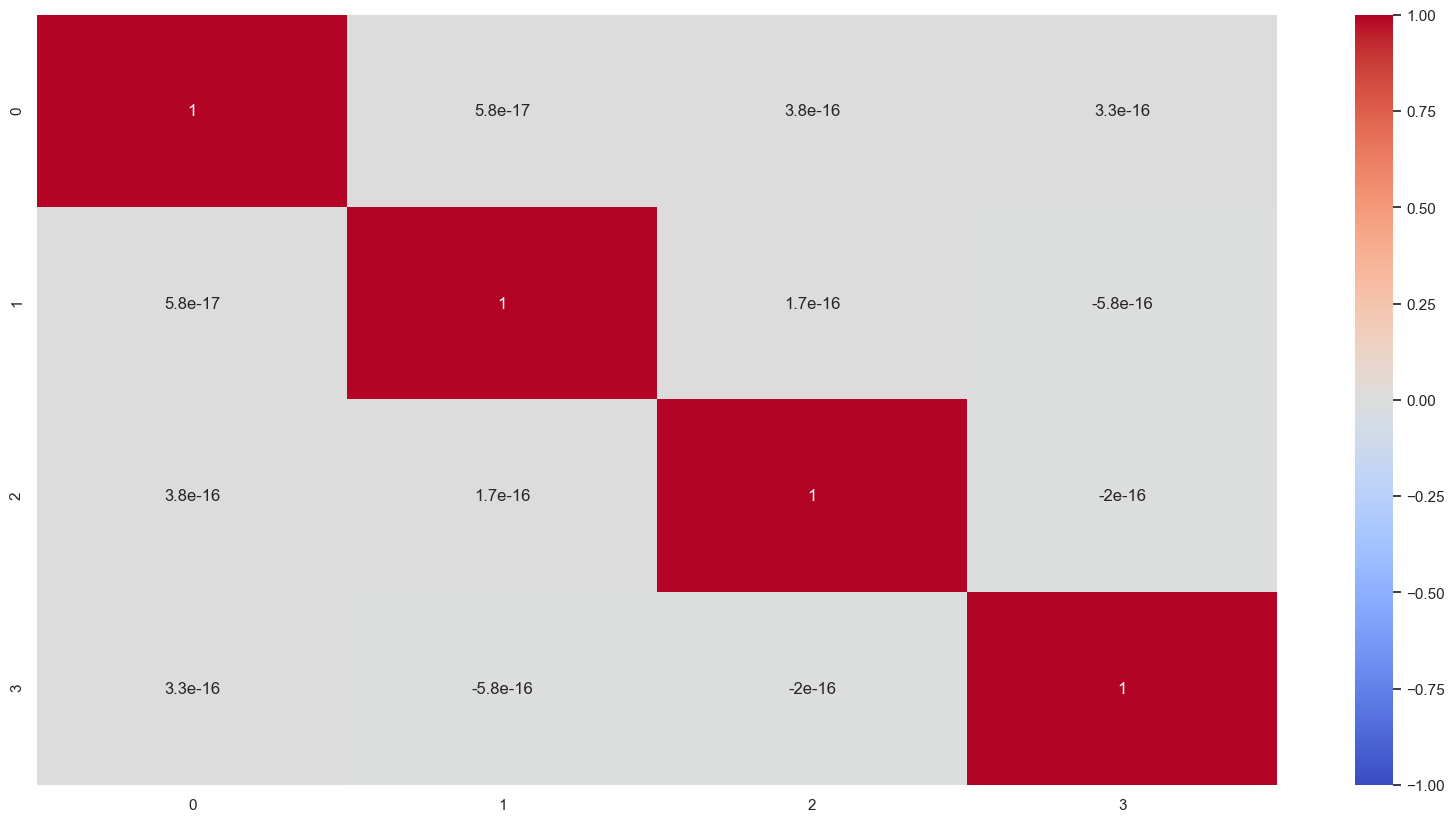

In [51]:
# Plot a correlation matrix to determine if there are any redundancies
corr_new = pd.DataFrame(train_x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr_new, 
                 xticklabels=corr_new.columns,
                 yticklabels=corr_new.columns,
                 annot=True,
                 cmap = 'coolwarm',
                 vmin = -1,
                 vmax = 1)
                 

训练以下模型：

支持向量回归器 （SVR）


多层感知器（MLP）：
多层感知器由输入层和输出层组成，具有多个可能的隐藏层。


随机森林回归器：
随机森林使用集成学习进行回归/分类。与单个树相比，训练了多个决策树，并汇集了它们各自的预测，以获得更准确的结果。在回归任务中，模型的输出是所有决策树预测的平均值。


以下四种算法属于*提升算法*系列。提升是一种集成建模技术，它试图从弱分类器的数量中构建一个健壮的分类器。它是通过使用串联的弱模型来构建模型来完成的。首先，根据训练数据构建模型。然后构建第二个模型，该模型尝试纠正第一个模型中存在的错误。此过程将继续，并添加模型，直到正确预测完整的训练数据集或添加最大数量的模型。


XGBoost 回归器：
XGBoost（或极限梯度提升）是一种基于决策树的集成机器学习算法，它使用梯度提升算法。


AdaBoost 回归器：
AdaBoost（或自适应提升）是实现提升算法的第一个成功方法。AdaBoost 算法涉及使用非常短（一级）的决策树作为按顺序添加到融合中的弱学习器。


LightBGM 回归器：
LightBGM（或光增强梯度机）通过添加一种自动特征选择以及专注于具有较大梯度的增强示例来扩展梯度提升算法。这导致训练的显着加速和预测性能的提高。


CatBoost Regressor：
CatBoost是由Yandex开发的开源库。它是一个深度梯度提升库，它使用遗忘决策树来生长平衡树。

In [ ]:
def eval_svr(train, test, training = True):
    '''
    模型为全局变量，如果training为True，重新训练模型
    '''
    global svr

    if training:
        # Define a SVM regressor with a Gaussian kernel
        svr = SVR()

        # Train the model
        svr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(svr.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_mlp(train, test, training = True, layer_size = 100, max_iter = 1000):
    global mlp
    
    if training: 
        # Define a regressor with 1 hidden layer
        mlp = MLPRegressor(hidden_layer_sizes = (layer_size,), max_iter = max_iter)
        # Train the model
        mlp.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(mlp.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_rf(train, test, training = True, n_estimators = 100):
    global regressor
    
    if training:
        # Define a random forest regressor
        regressor = RandomForestRegressor(n_estimators = n_estimators)
        # Train the model
        regressor.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(regressor.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_xgb(train, test, training = True):
    global xgbr
    
    if training:
        # Define a xgb regressor
        xgbr = XGBRegressor()
        # Train the model
        xgbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = xgbr.predict(test[0])
    print(blue(f"Evaluating the XGBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_abr(train, test, training = True):
    global abr
    
    if training:
        # Define a adaboost regressor
        abr = AdaBoostRegressor()
        # Train the model
        abr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = abr.predict(test[0])
    print(blue(f"Evaluating the AdaBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_lgbmr(train, test, training = True):
    global lgbmr

    if training:
        # Define a LightBGM regressor
        lgbmr = LGBMRegressor()
        # Train the model
        lgbmr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = lgbmr.predict(test[0])
    print(blue(f"Evaluating the LightGBM Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_cbr(train, test, training = True):
    global cbr
    
    if training:
        # Define a LightBGM regressor
        cbr = CatBoostRegressor()
        # Train the model
        cbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = cbr.predict(test[0])
    print(blue(f"Evaluating the CatBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [ ]:
train, test = [train_x, train_y], [test_x, test_y]

eval_svr(train, test, training = True)
eval_rf(train, test, training = True)
eval_xgb(train, test, training = True)
eval_abr(train, test, training = True)
eval_mlp(train, test, training = True)
eval_lgbmr(train, test, training = True)
eval_cbr(train, test, training = True)

Evaluating the Support Vector Regressor...
R2 Score = 0.8864
RMSE = 0.0663
Evaluating the Random Forest Regressor...
R2 Score = 0.9950
RMSE = 0.0140
Evaluating the XGBoost Regressor...
R2 Score = 0.9928
RMSE = 0.0167
Evaluating the AdaBoost Regressor...
R2 Score = 0.9939
RMSE = 0.0154
Evaluating the Multi-Layer Perceptron...
R2 Score = 0.4604
RMSE = 0.1446
Evaluating the LightGBM Regressor...
R2 Score = 0.9948
RMSE = 0.0141
Learning rate set to 0.029803
0:	learn: 0.1832401	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.1790342	total: 62.1ms	remaining: 31s
2:	learn: 0.1756130	total: 63.1ms	remaining: 21s
3:	learn: 0.1720753	total: 64ms	remaining: 15.9s
4:	learn: 0.1689009	total: 65ms	remaining: 12.9s
5:	learn: 0.1656373	total: 65.9ms	remaining: 10.9s
6:	learn: 0.1626907	total: 66.7ms	remaining: 9.47s
7:	learn: 0.1597865	total: 67.6ms	remaining: 8.39s
8:	learn: 0.1571745	total: 68.7ms	remaining: 7.56s
9:	learn: 0.1541579	total: 69.7ms	remaining: 6.9s
10:	learn: 0.1505954	total: 70.5ms	remain

### 超参数调节


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'n_estimators' : [100, 200, 500]
    }

    print(blue('Performing hyperparameter tuning for the XGBoost Regressor', 'bold'))
    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5, verbose = 1, n_jobs = -1, error_score = 0.00)

    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

    param_tuning = {
        'n_estimators':[10, 50, 100, 500, 1000],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1]
    }

    print(blue('Performing hyperparameter tuning for the AdaBoost Regressor', 'bold'))
    abr_model = AdaBoostRegressor()
    gsearch = GridSearchCV(estimator = abr_model, 
                           param_grid = param_tuning,
                           cv = 5, n_jobs = -1, verbose = 1, error_score = 0.00)
    
    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

    param_tuning = {
        'max_depth': (9, 13),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (10, 30, 50)
    }

    print(blue('Performing hyperparameter tuning for the LightGBM Regressor', 'bold'))
    lgbmr_model = LGBMRegressor()
    gsearch = GridSearchCV(estimator = lgbmr_model, 
                           param_grid = param_tuning,
                           cv = 5, verbose = 1, n_jobs = -1, error_score = 0.00)
    
    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

    param_tuning = {
        'iterations': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6, 8]
    }

    print(blue('Performing hyperparameter tuning for the CatBoost Regressor', 'bold'))
    cbr_model = CatBoostRegressor()
    gsearch = GridSearchCV(estimator = cbr_model, 
                           param_grid = param_tuning,
                           cv = 5, verbose = 1, n_jobs = -1, error_score = 0.00)
    
    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

In [ ]:
hyperParameterTuning(train[0], train[1])

Performing hyperparameter tuning for the XGBoost Regressor
Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}
Performing hyperparameter tuning for the AdaBoost Regressor
Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'learning_rate': 1, 'n_estimators': 1000}
Performing hyperparameter tuning for the LightGBM Regressor
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 9, 'min_child_weight': 10, 'min_split_gain': 0.001}
Performing hyperparameter tuning for the CatBoost Regressor
Fitting 5 folds for each of 48 candidates, totalling 240 fits
0:	learn: 0.1808090	total: 358us	remaining: 71.3ms
1:	learn: 0.1733668	total: 805us	remaining: 79.7ms
2:	learn: 0.1663956	total: 1.02ms	remaining: 67.2ms
3:	learn: 0.1599378	total: 1.28ms	remaining: 63ms
4:	learn: 0.1542467	total: 1.51ms	remaining: 58.9ms
5:	learn: 0.1484993	total: 1.79ms	remaining: 57.9ms
6:	learn: 0.14

In [ ]:
# Using an Artificial Neural Network with LSTM and Dense layers
# Importing required libraries
from keras.models import Model

In [ ]:
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping
import tqdm.notebook as tq

def create_model(lstm_size = 32, dense_size = 10, plot = False, dpi = 96):
    '''
    返回一个ann模型

    参数：
    lstm_size：LSTM层的大小
    dense_size：Dense层的大小
    plot：是否绘制模型图
    dpi：绘制模型图的dpi

    '''
    inputs = Input(shape = (8,1), name = 'Input_features')
    lstm = LSTM(lstm_size, input_shape = (8,1))(inputs)
    dense2 = Dense(dense_size)(lstm)
    output = Dense(1, name = 'Output_Layer')(dense2)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    if plot: 
        print("Visualizing the model and its layers :")
        display(plot_model(model, show_shapes = True, dpi = dpi))

    return model

def eval_nn(train, test, 
            training = True, 
            lstm_size = 32, 
            dense_size = 10, 
            plot = False, dpi = 96, 
            epochs = 100, 
            ncols = None, 
            verbose = 1, 
            return_results = True):
    '''
    使用神经网络进行预测

    参数：
    train：训练集
    test：测试集
    training：是否训练模型
    lstm_size：LSTM层的大小
    dense_size：Dense层的大小
    plot：是否绘制模型图
    dpi：绘制模型图的dpi
    epochs：训练的轮数
    ncols：tqdm的列数
    verbose：是否显示训练过程
    return_results：是否返回预测结果
    
    '''
    global nn

    if training: train_x = train[0].reshape(-1,8,1)
    test_x = test[0].reshape(-1,8,1)

    if training:    
        es_callback = EarlyStopping(monitor = 'loss', patience = 20)
        
        if verbose == 1 or verbose ==0: 
            tqdm_callback = TqdmCallback(verbose = 0)
            callbacks = [tqdm_callback, es_callback] 
        else: callbacks = [es_callback]
        
        # Define the model
        nn = create_model(lstm_size = lstm_size, dense_size = dense_size, plot = plot, dpi = dpi)
        # Train the model
        nn.fit(train_x, train[1], 
               epochs = epochs, 
               batch_size = 1, 
               verbose = 0, 
               callbacks = callbacks
              )

    # Test the model returning mean accuracy
    y_pred = nn.predict(test[0])
    rmse = np.sqrt(nn.evaluate(test_x, test[1], verbose = verbose))
    r2 = r2_score(test[1], y_pred)
    if verbose == 1:
        print(blue(f"Evaluating the Artificial Neural Network...", 'bold'))
        print(f"R2 Score = {r2:.4f}")
        print(f"RMSE = {rmse:.4f}")
    if return_results: return rmse

In [ ]:
# Defining a model with 25 neurons in the LSTM layer and 10 neurons in the Dense layer
eval_nn(train, test, 
        training = True, 
        lstm_size = 32, 
        dense_size = 10,
        plot = False,
        epochs = 100,
        verbose = 1, 
        return_results = False)

 33%|███▎      | 33/100 [00:09<00:20,  3.32epoch/s, loss=0.000831]


2/2 [==============================] - 0s 3ms/step - loss: 8.9704e-04
Evaluating the Artificial Neural Network...
R2 Score = 0.9769
RMSE = 0.0300


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
    # Hyperparameter tuning for the Artificial Neural Network
'''
lstm_sizes = [8, 10, 16, 25, 32]
dense_sizes = [4, 8, 10]

comb_nn = [(lstm_sizes[i], dense_sizes[j]) for i in range(len(lstm_sizes)) for j in range(len(dense_sizes))]

min = 0.1
for i in tq.trange(len(comb_nn)):
    lstm_size = comb_nn[i][0]
    dense_size = comb_nn[i][1]
    results = eval_nn(train, test, 
                      training = True,
                      lstm_size = lstm_size, 
                      dense_size = dense_size, 
                      plot = False, 
                      verbose = 0,
                      epochs = 100,
                      return_results = True)
    if results < min:
        print(f"Updating minimum loss..... \t Iteration loss = {results:.4f} \t Previous Minimum loss = {min:.4f}")
        print(f"Best Params = {comb_nn[i]}")
        lstm_best = comb_nn[i][0]
        dense_best = comb_nn[i][1]
        min = results
print(f"Best results obtained with LSTM layer size = {lstm_best} \t Dense layer size = {dense_best}")
'''

'\nlstm_sizes = [8, 10, 16, 25, 32]\ndense_sizes = [4, 8, 10]\n\ncomb_nn = [(lstm_sizes[i], dense_sizes[j]) for i in range(len(lstm_sizes)) for j in range(len(dense_sizes))]\n\nmin = 0.1\nfor i in tq.trange(len(comb_nn)):\nlstm_size = comb_nn[i][0]\ndense_size = comb_nn[i][1]\nresults = eval_nn(train, test, \n                  training = True,\n                  lstm_size = lstm_size, \n                  dense_size = dense_size, \n                  plot = False, \n                  verbose = 0,\n                  epochs = 100,\n                  return_results = True)\nif results < min:\n    print(f"Updating minimum loss..... \t Iteration loss = {results:.4f} \t Previous Minimum loss = {min:.4f}")\n    print(f"Best Params = {comb_nn[i]}")\n    lstm_best = comb_nn[i][0]\n    dense_best = comb_nn[i][1]\n    min = results\nprint(f"Best results obtained with LSTM layer size = {lstm_best} \t Dense layer size = {dense_best}")\n'

In [ ]:
#ann_turning()

0epoch [00:00, ?epoch/s]

Visualizing the model and its layers :


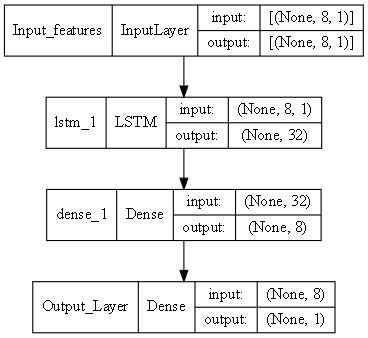

 30%|███       | 30/100 [00:08<00:20,  3.45epoch/s, loss=0.000579]


2/2 [==============================] - 0s 2ms/step - loss: 0.0013
Evaluating the Artificial Neural Network...
R2 Score = 0.9666
RMSE = 0.0360


In [ ]:
eval_nn(train, test, 
        training = True, 
        lstm_size = 32, 
        dense_size = 8,
        plot = True, dpi = 80,
        epochs = 100,
        verbose = 1, 
        return_results = False)

### 模型评估


In [ ]:
# This function applies the previously trained models to the data of other cells
# which have not been used for the training process

def evaluate_cell(cell_number, model_type, axes, position):
    '''
    使用特定电池对模型进行评估

    参数：
    cell_number：电池编号
    model_type：模型类型
    axes：绘图的axes
    position：绘图的位置
    
    '''
    x, y = preprocessing(cell_number, 16)
    x = scaler.transform(x)
    x = pca.transform(x)
    
    if model_type == 'xgb' or model_type == 'all': 
        eval_xgb(_, [x, y], training = False)
        axes[position[0], position[1]].plot(xgbr.predict(x), label = "XGBoost Regressor")
    if model_type == 'abr' or model_type == 'all': 
        eval_abr(_, [x, y], training = False)
        axes[position[0], position[1]].plot(abr.predict(x), label = "abr")

    if model_type == 'cbr' or model_type == 'all': 
        eval_cbr(_, [x, y], training = False)
        axes[position[0], position[1]].plot(cbr.predict(x), label = "cbr")

    if model_type == 'svr' or model_type == 'all': 
        eval_svr(_, [x, y], training = False)
        axes[position[0], position[1]].plot(svr.predict(x), label = "svr")

    if model_type == 'lgbmr' or model_type == 'all': 
        eval_lgbmr(_, [x, y], training = False)
        axes[position[0], position[1]].plot(lgbmr.predict(x), label = "lgbmr")

        
    
    if model_type == 'rf' or model_type == 'all':
        eval_rf(_, [x, y], training = False)
        axes[position[0], position[1]].plot(regressor.predict(x), label = "Random Forest Regressor")
    
    if model_type == 'nn' or model_type == 'all':
        eval_nn(_, [x, y], training = False, plot = False)
        axes[position[0], position[1]].plot(nn.predict(x.reshape(-1,8,1)), label = "Artificial Neural Network")
    
    axes[position[0], position[1]].plot(y.reshape(-1,1), label = "True labels")
    axes[position[0], position[1]].legend()
    axes[position[0], position[1]].set_xlabel("Cycles", fontsize = 14)
    axes[position[0], position[1]].set_ylabel("Capacity of the battery (Ahr)", fontsize = 14)

Applying the previously trained models to data from cell 7
Evaluating the XGBoost Regressor...
R2 Score = 0.9739
RMSE = 0.0259
6/6 [==============================] - 0s 1ms/step - loss: 0.0014
Evaluating the Artificial Neural Network...
R2 Score = 0.9470
RMSE = 0.0369
Evaluating the Random Forest Regressor...
R2 Score = 0.9806
RMSE = 0.0224
Evaluating the Support Vector Regressor...
R2 Score = 0.8236
RMSE = 0.0674
Evaluating the AdaBoost Regressor...
R2 Score = 0.9762
RMSE = 0.0248
Evaluating the CatBoost Regressor...
R2 Score = 0.9379
RMSE = 0.0400
Evaluating the LightGBM Regressor...
R2 Score = 0.9757
RMSE = 0.0250
Comparing all models at once
Evaluating the XGBoost Regressor...
R2 Score = 0.9739
RMSE = 0.0259
Evaluating the AdaBoost Regressor...
R2 Score = 0.9762
RMSE = 0.0248
Evaluating the CatBoost Regressor...
R2 Score = 0.9379
RMSE = 0.0400
Evaluating the Support Vector Regressor...
R2 Score = 0.8236
RMSE = 0.0674
Evaluating the LightGBM Regressor...
R2 Score = 0.9757
RMSE = 0.0

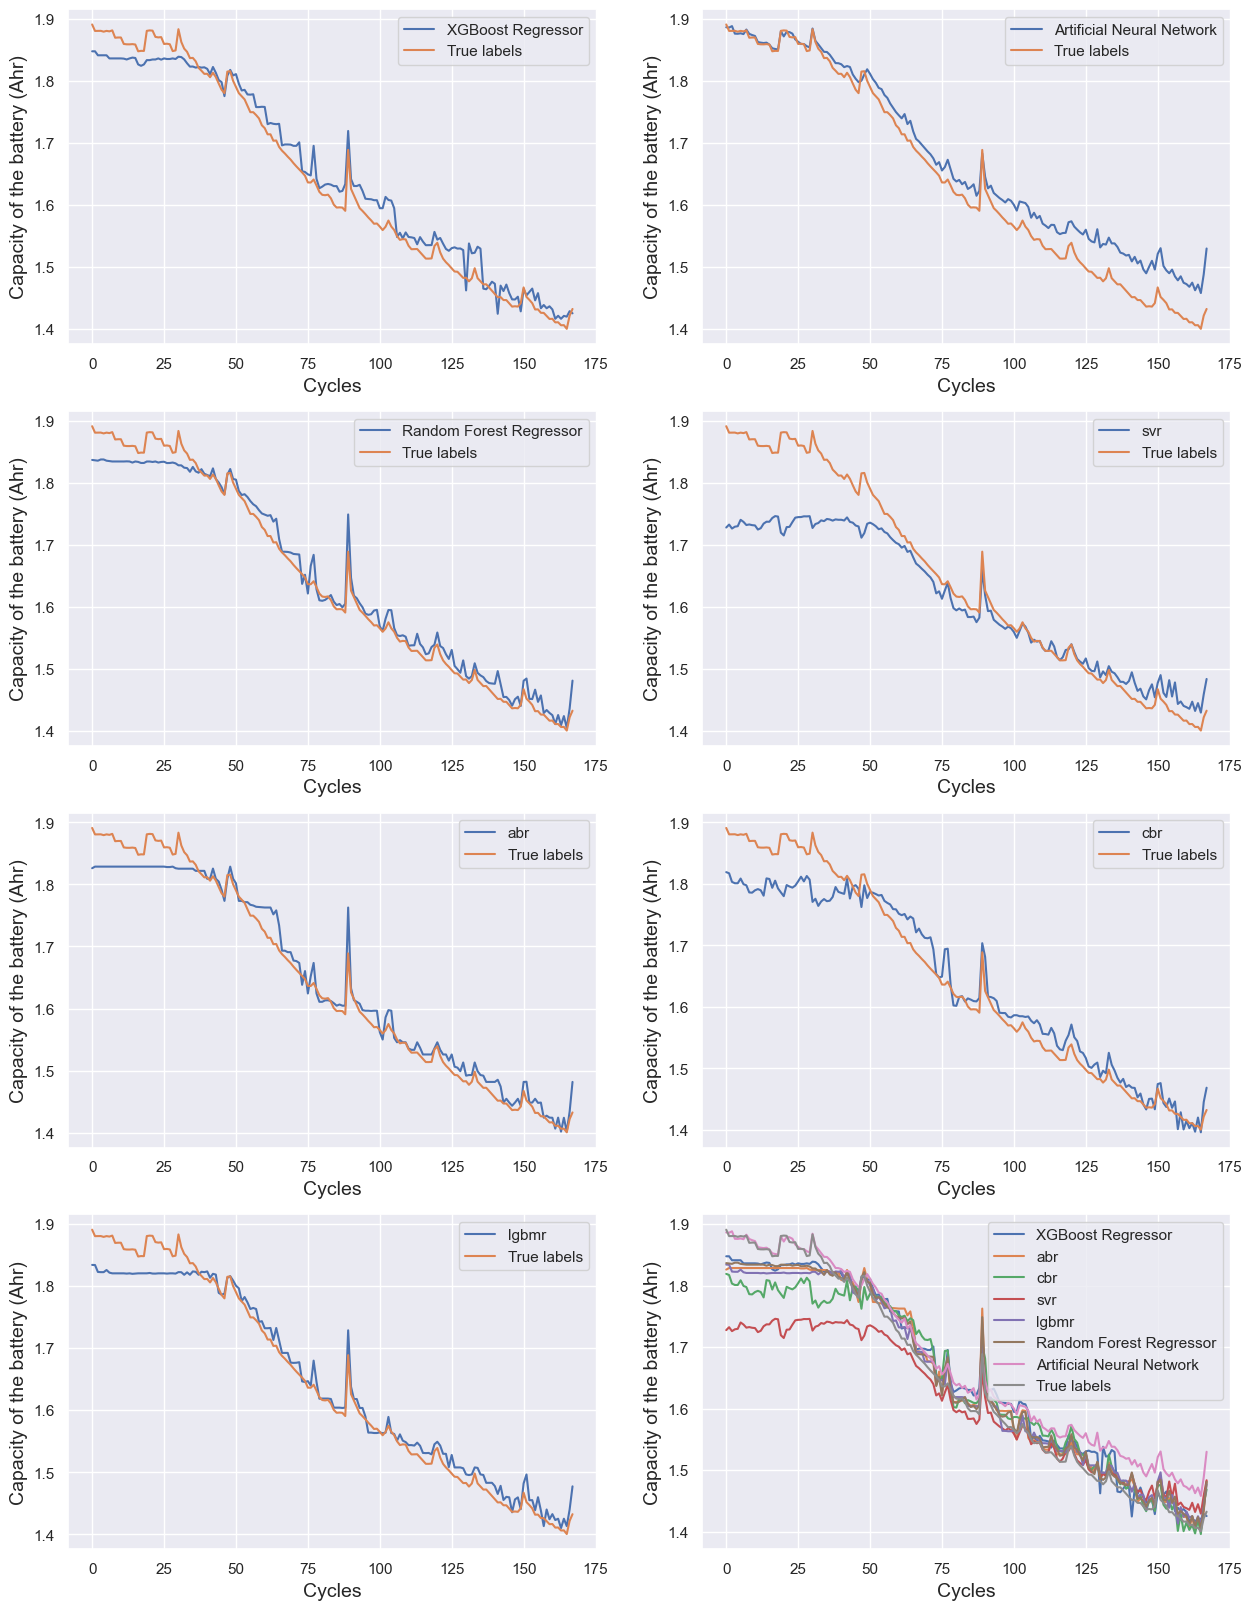

In [ ]:
print(red("Applying the previously trained models to data from cell 7", 'bold'))
fig, axes = plt.subplots(4, 2, figsize = (15, 20))

evaluate_cell(7, 'xgb', axes, (0,0))
evaluate_cell(7, 'nn', axes, (0,1))
evaluate_cell(7, 'rf', axes, (1,0))
evaluate_cell(7, 'svr', axes, (1,1))
evaluate_cell(7, 'abr', axes, (2,0))
evaluate_cell(7, 'cbr', axes, (2,1))
evaluate_cell(7, 'lgbmr', axes, (3,0))
print(red("Comparing all models at once", 'bold'))
evaluate_cell(7, 'all', axes, (3,1))

In [ ]:
def plot_on_battery(battery_num):
    print(yellow("Applying the previously trained models to data from cell {}".format(battery_num), 'bold'))
    fig, axes = plt.subplots(4, 2, figsize = (15, 20))

    evaluate_cell(battery_num, 'xgb', axes, (0,0))
    evaluate_cell(battery_num, 'nn', axes, (0,1))
    evaluate_cell(battery_num, 'rf', axes, (1,0))
    evaluate_cell(battery_num, 'svr', axes, (1,1))
    evaluate_cell(battery_num, 'abr', axes, (2,0))
    evaluate_cell(battery_num, 'cbr', axes, (2,1))
    evaluate_cell(battery_num, 'lgbmr', axes, (3,0))
    print(yellow("Comparing all models at once", 'bold'))
    evaluate_cell(battery_num, 'all', axes, (3,1))

Applying the previously trained models to data from cell 7
Evaluating the XGBoost Regressor...
R2 Score = 0.9739
RMSE = 0.0259
6/6 [==============================] - 0s 2ms/step - loss: 0.0014
Evaluating the Artificial Neural Network...
R2 Score = 0.9470
RMSE = 0.0369
Evaluating the Random Forest Regressor...
R2 Score = 0.9806
RMSE = 0.0224
Evaluating the Support Vector Regressor...
R2 Score = 0.8236
RMSE = 0.0674
Evaluating the AdaBoost Regressor...
R2 Score = 0.9762
RMSE = 0.0248
Evaluating the CatBoost Regressor...
R2 Score = 0.9379
RMSE = 0.0400
Evaluating the LightGBM Regressor...
R2 Score = 0.9757
RMSE = 0.0250
Comparing all models at once
Evaluating the XGBoost Regressor...
R2 Score = 0.9739
RMSE = 0.0259
Evaluating the AdaBoost Regressor...
R2 Score = 0.9762
RMSE = 0.0248
Evaluating the CatBoost Regressor...
R2 Score = 0.9379
RMSE = 0.0400
Evaluating the Support Vector Regressor...
R2 Score = 0.8236
RMSE = 0.0674
Evaluating the LightGBM Regressor...
R2 Score = 0.9757
RMSE = 0.0

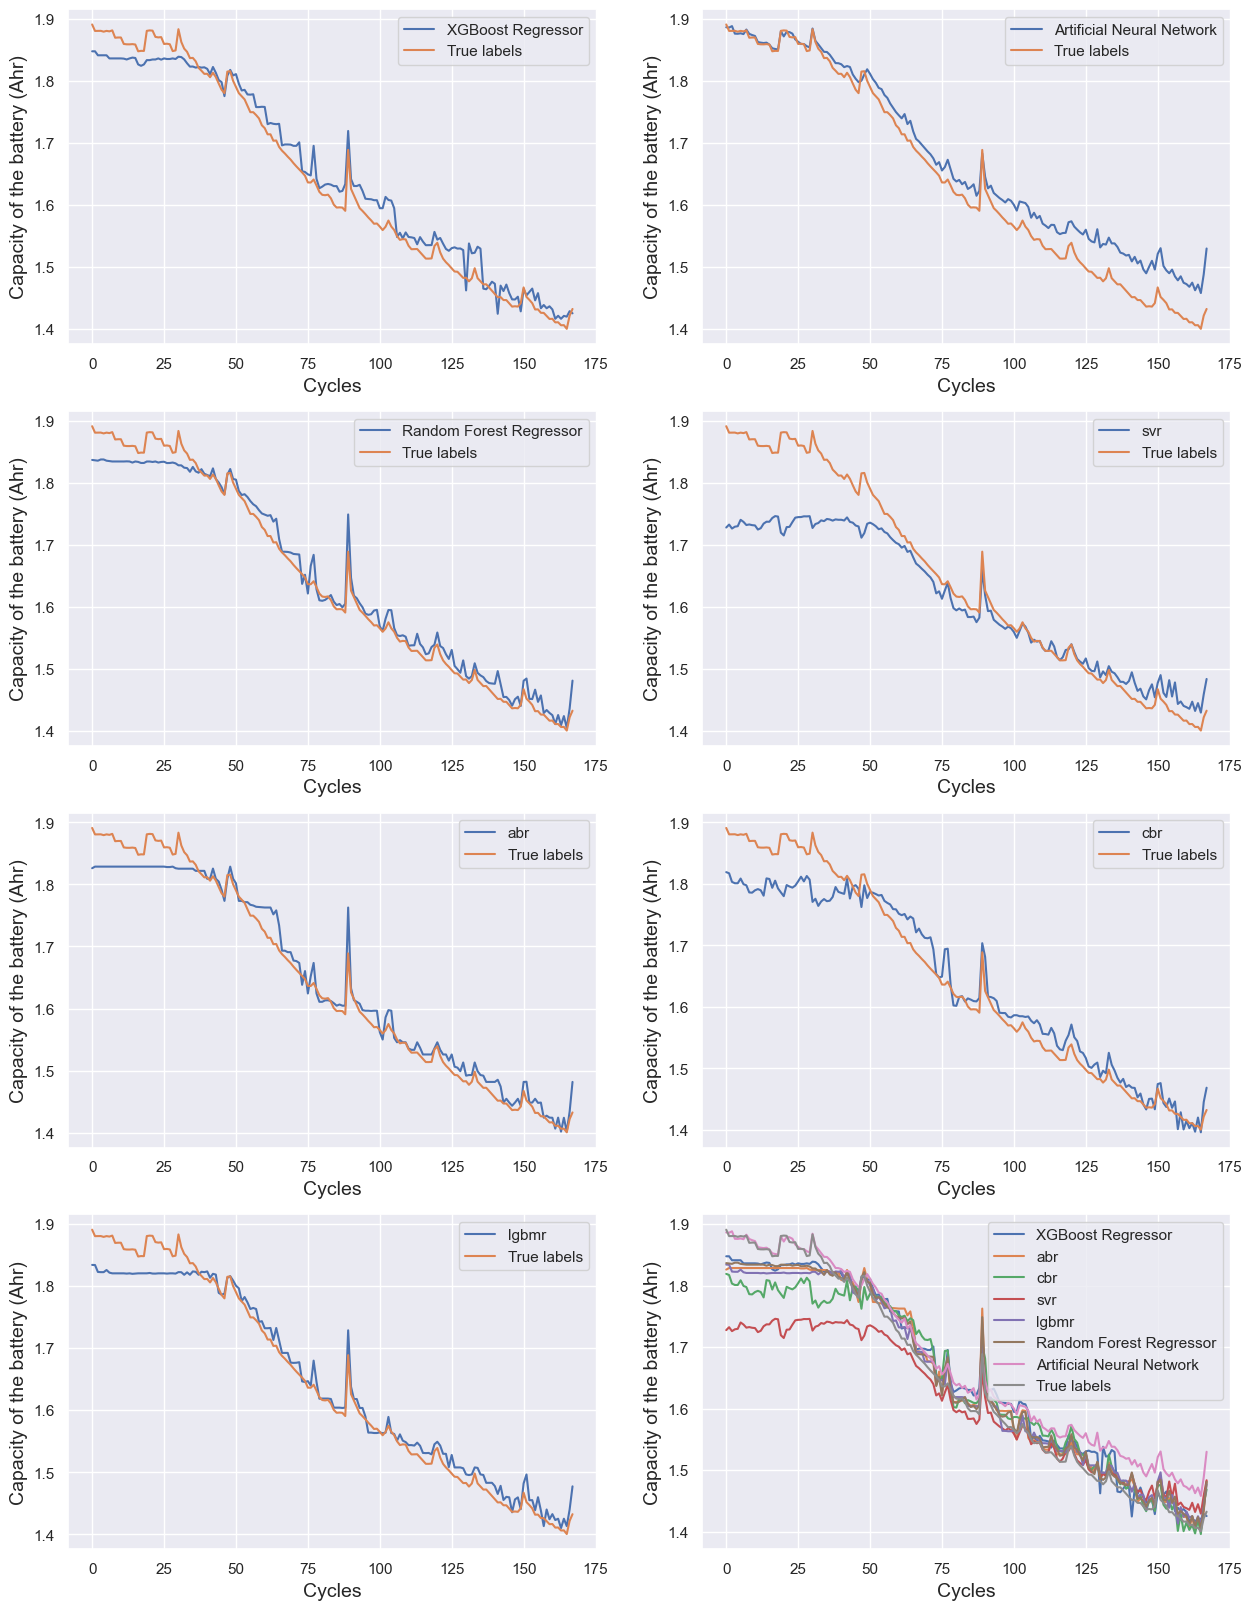

In [ ]:
plot_on_battery(7)

In [ ]:
# Evaluating all the models on cell number 7

x, y = preprocessing(7, 16)
x = scaler.transform(x)
x = pca.transform(x)


eval_svr(_, [x,y], training = False)
eval_rf(_, [x,y], training = False)
eval_xgb(_, [x,y], training = False)
eval_abr(_, [x,y], training = False)
eval_lgbmr(_, [x,y], training = False)
eval_cbr(_, [x,y], training = False)
eval_nn(_, [x,y], training = False, plot = False)

Evaluating the Support Vector Regressor...
R2 Score = 0.8236
RMSE = 0.0674
Evaluating the Random Forest Regressor...
R2 Score = 0.9806
RMSE = 0.0224
Evaluating the XGBoost Regressor...
R2 Score = 0.9739
RMSE = 0.0259
Evaluating the AdaBoost Regressor...
R2 Score = 0.9762
RMSE = 0.0248
Evaluating the LightGBM Regressor...
R2 Score = 0.9757
RMSE = 0.0250
Evaluating the CatBoost Regressor...
R2 Score = 0.9379
RMSE = 0.0400
6/6 [==============================] - 0s 2ms/step - loss: 0.0014
Evaluating the Artificial Neural Network...
R2 Score = 0.9470
RMSE = 0.0369


0.036927729175817645

### 模型分析与可解释性

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

def partial_dependence_plot(model, feature, ax, data = train[0], line_kw = {}):
    '''
    绘制特征的部分依赖图，用于评估模型的特征重要性，以及特征与目标变量之间的关系
    '''

    disp = PartialDependenceDisplay.from_estimator(model,
                                                  data,
                                                  feature,
                                                  kind="average",
                                                  n_jobs=3,
                                                  grid_resolution=20,
                                                  ax=ax,
                                                  line_kw=line_kw)
    disp.axes_[0][0].set_xlabel(f"Feature {feature}", fontsize=14)
    disp.axes_[0][0].set_ylabel("Partial Dependence", fontsize=14)
    return disp 

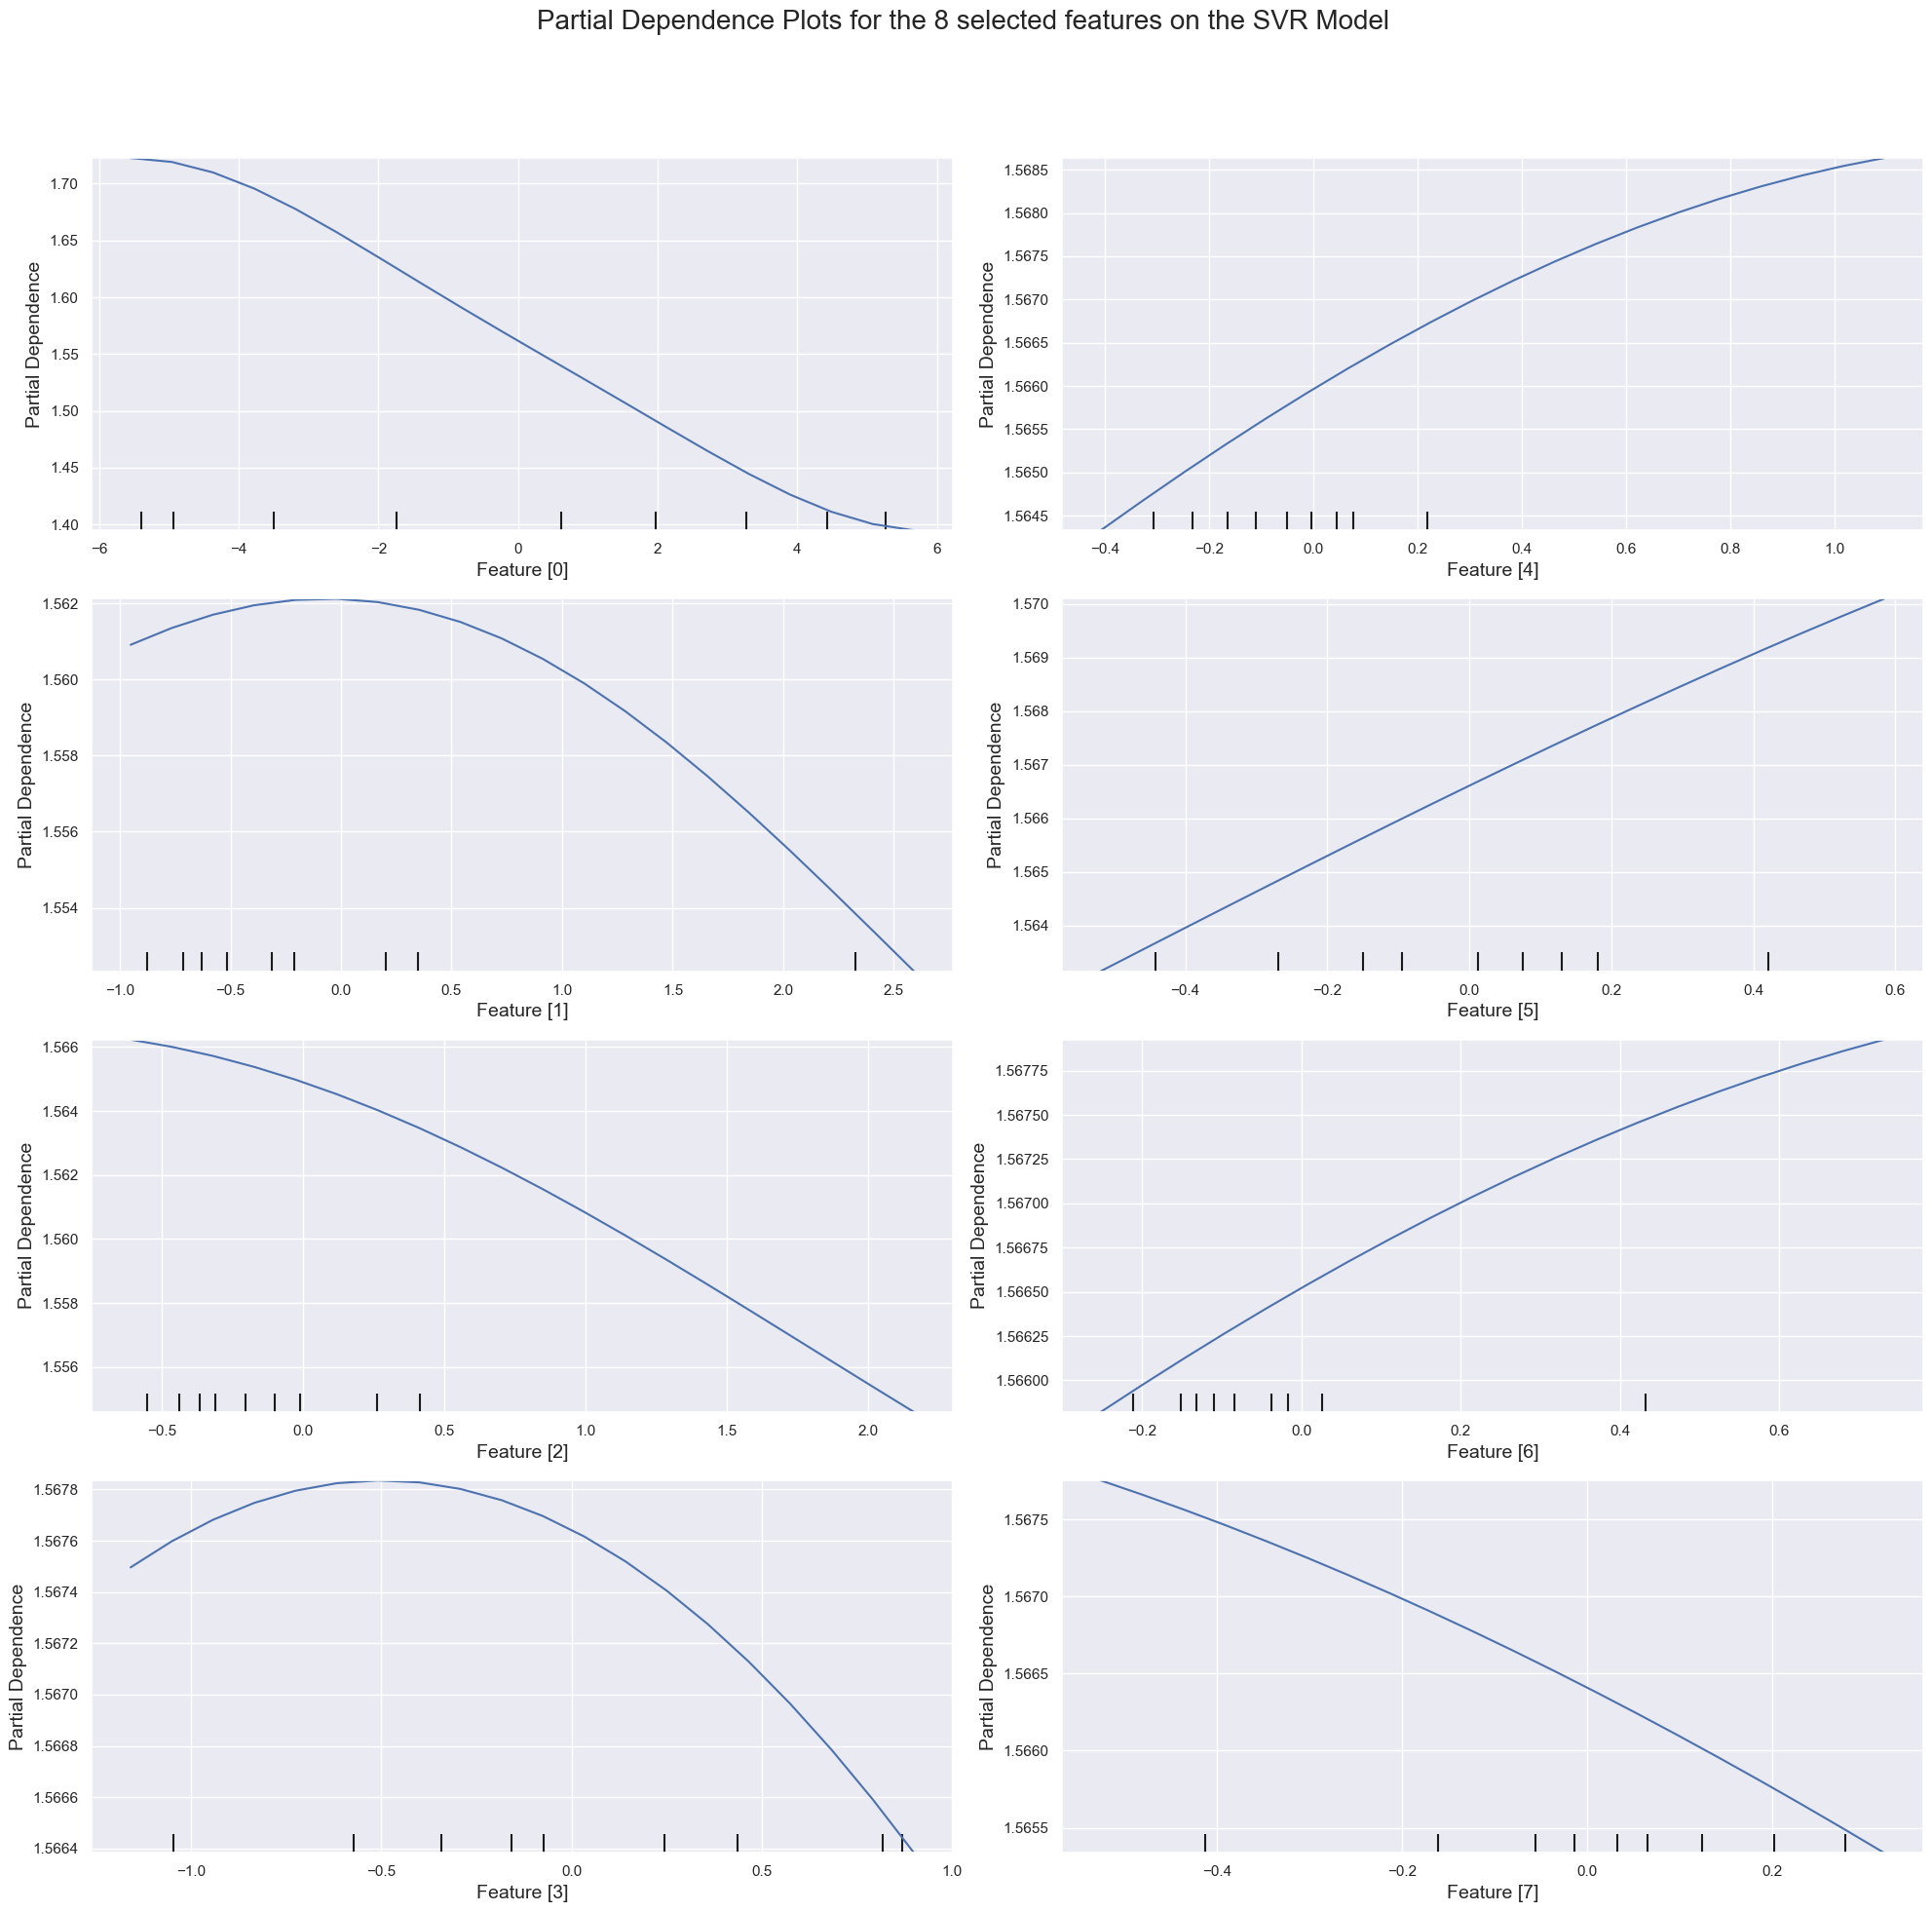

In [ ]:
features = {0: [[i] for i in range(4)],
            1: [[i] for i in range(4,8)]}

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the SVR Model \n", fontsize=20)

for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(svr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(svr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

1. 特征 0、4、7 具有单调递增的 PDP，并且可以与电池电压达到某些指定值的时间相关联。
2. 特征 1、2、3、6、5 具有递减的 PDP，并且可以与电池在每个放电周期中达到的最高温度相关联。

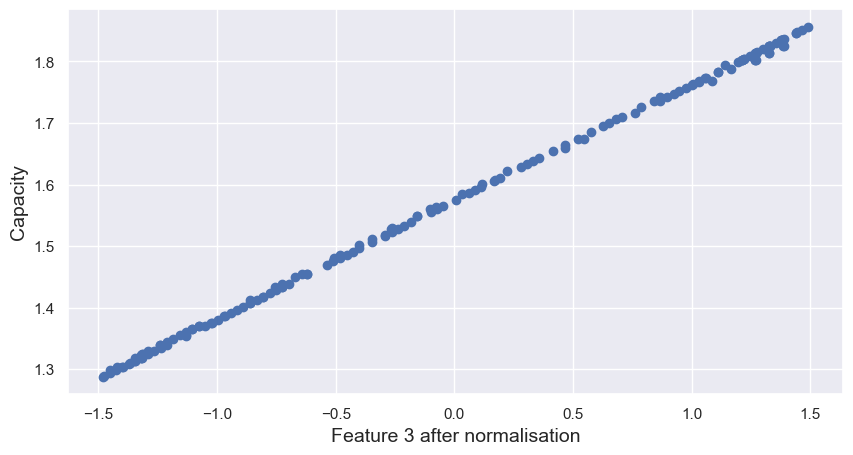

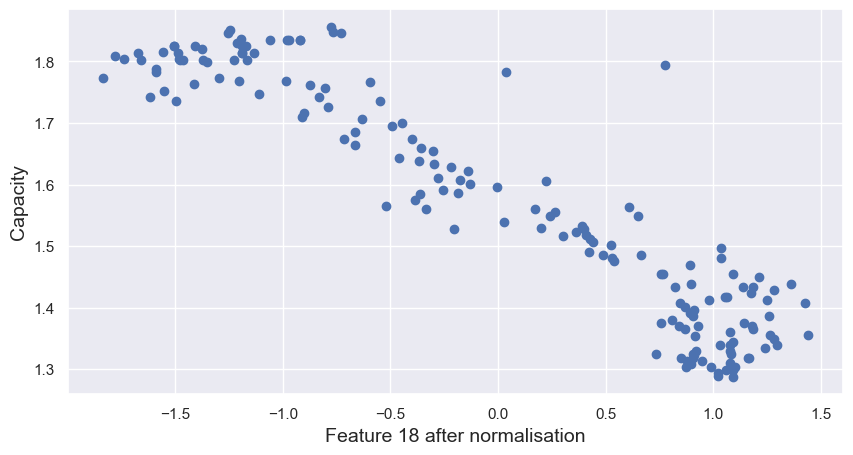

In [ ]:
x, y = preprocessing(5, 16)
x_std = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# 绘制散点图查看capacity与4v时间之间的关系
plt.figure(figsize=(10, 5))
plt.scatter(x_std[:, 2], y)
plt.xlabel('Feature 3 after normalisation', fontsize=14)
plt.ylabel('Capacity', fontsize=14)
plt.show()

# 绘制散点图查看capacity与max temperature之间的关系
plt.figure(figsize=(10, 5))
plt.scatter(x_std[:, 17], y)
plt.xlabel('Feature 18 after normalisation', fontsize=14)
plt.ylabel('Capacity', fontsize=14)
plt.show()

散点图和 PDP 之间有相当好的一致性。

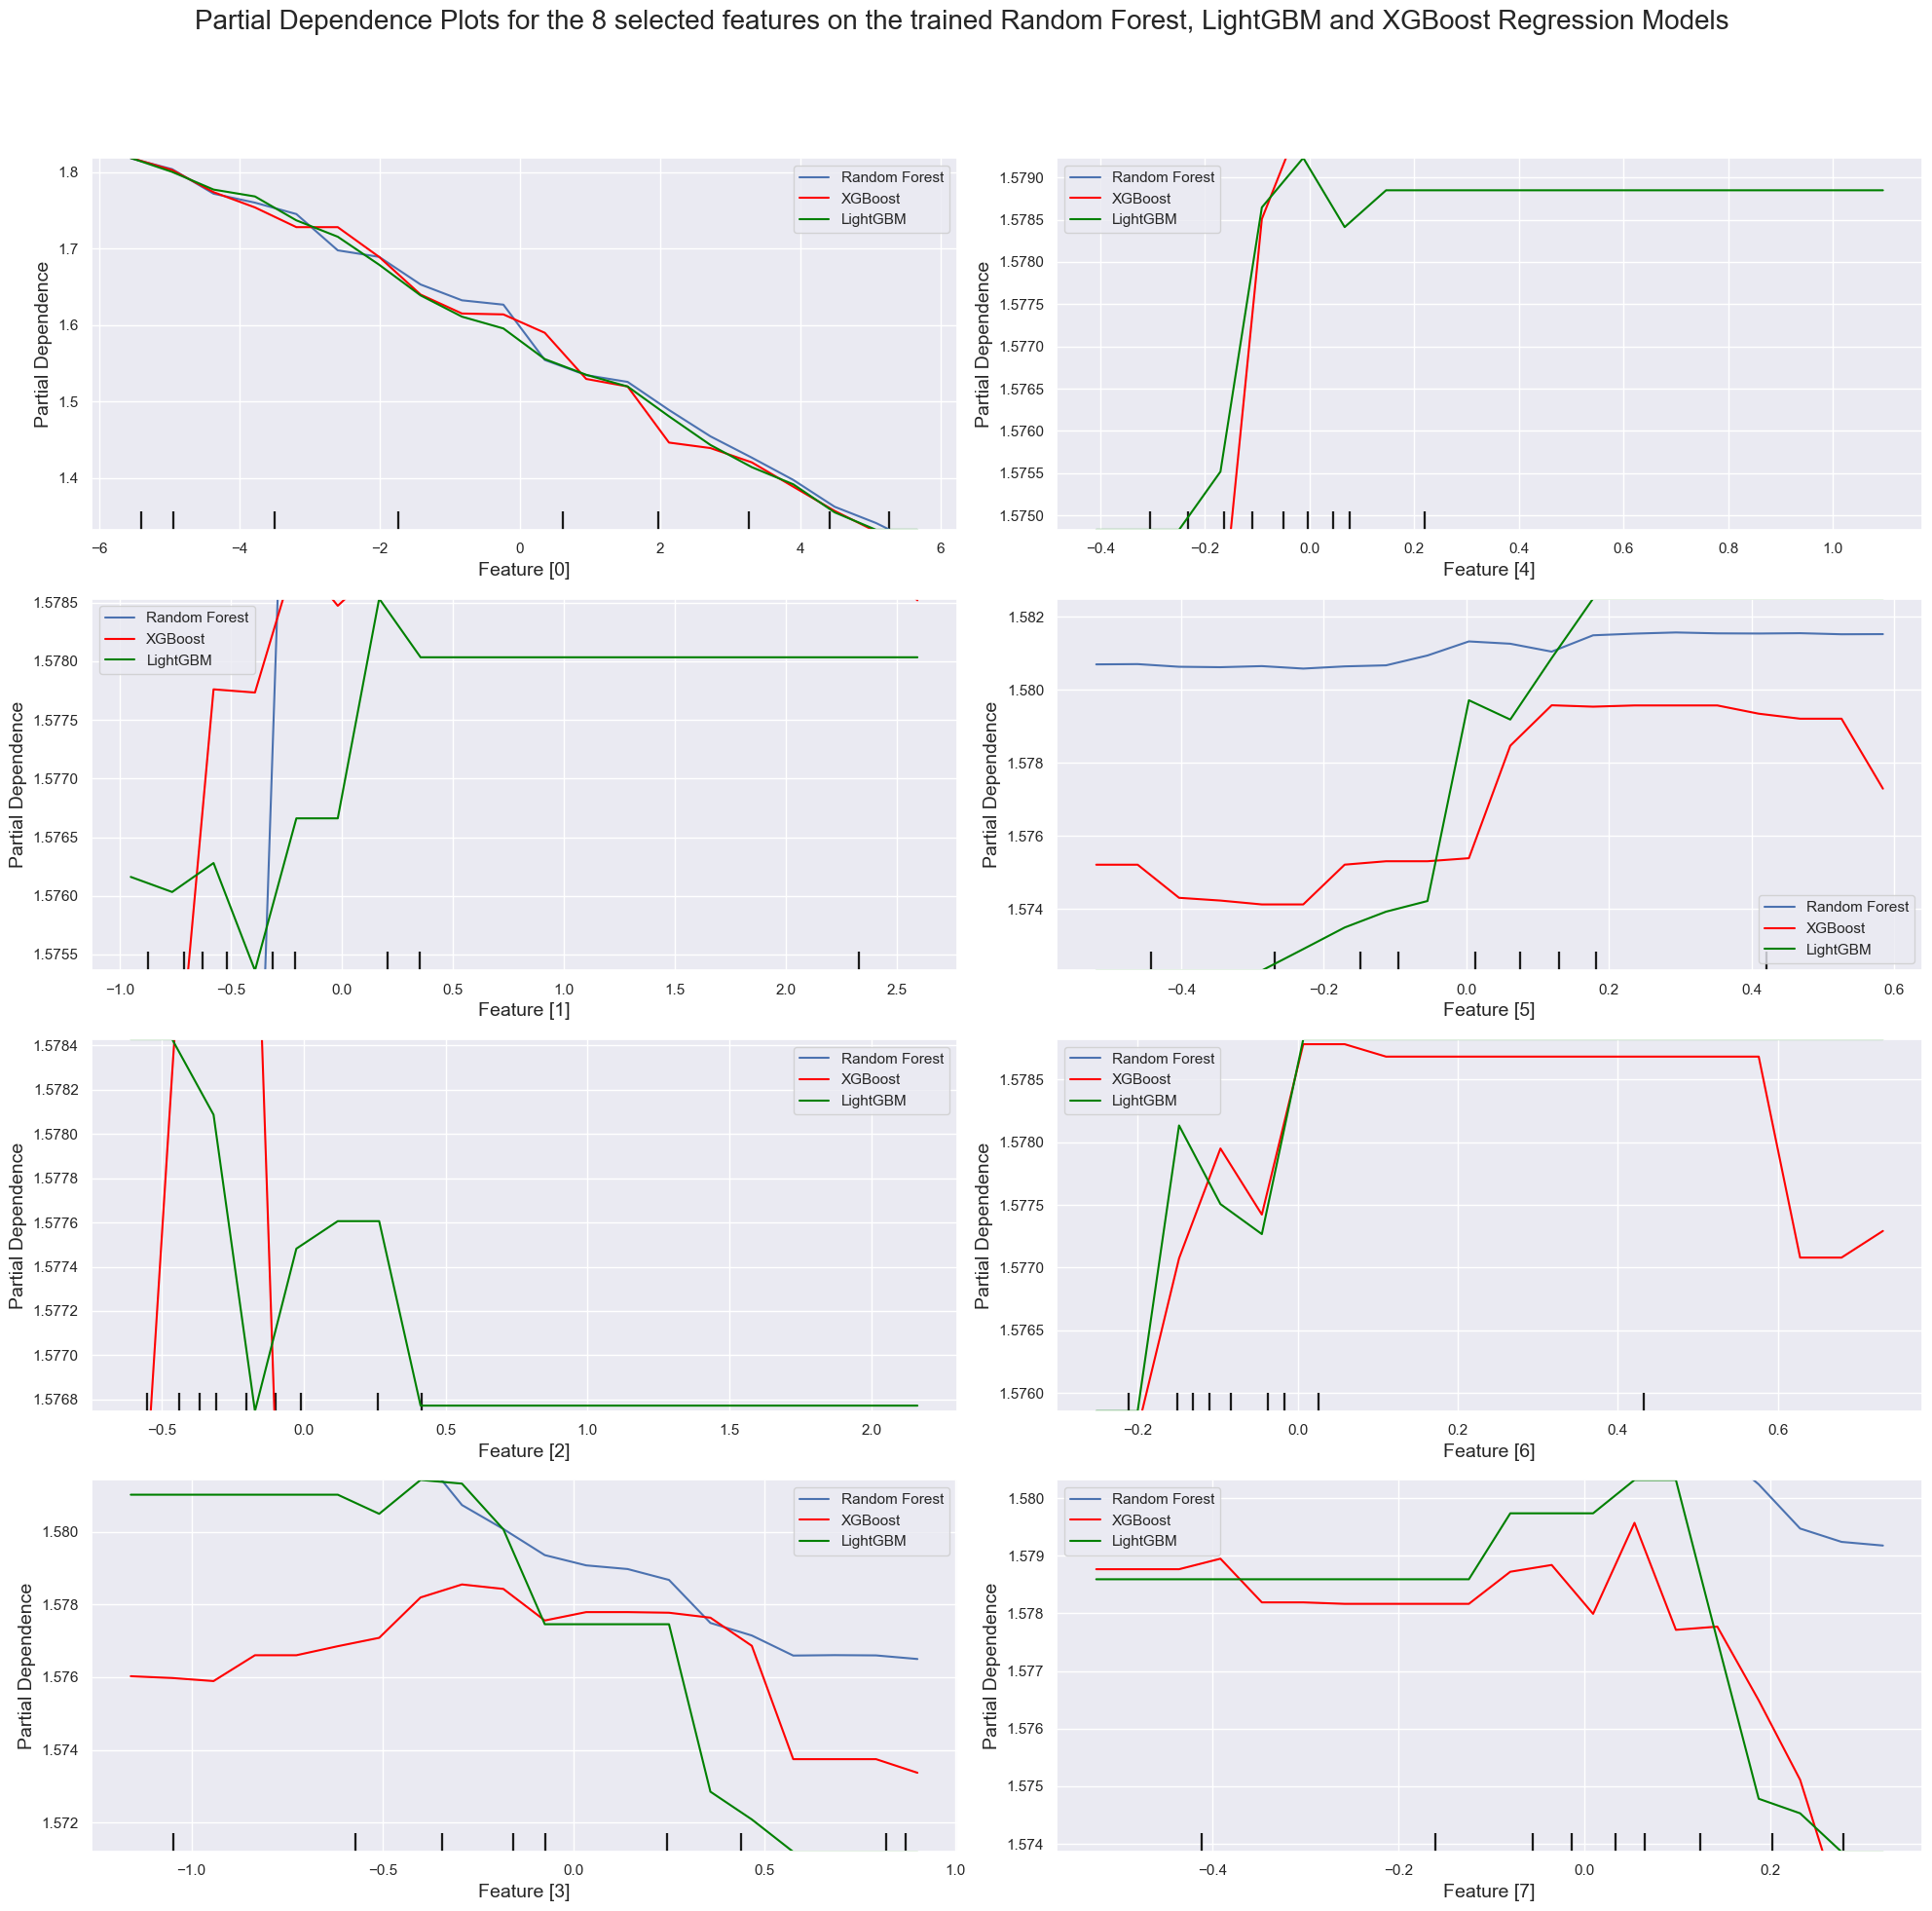

In [ ]:
features = {0: [[i] for i in range(4)],
            1: [[i] for i in range(4,8)]}

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the trained Random Forest, LightGBM and XGBoost Regression Models \n", fontsize=20)

base_displays = dict() # For storing all PartialDependanceDisplay instances
for (i, j) in zip(features[0], np.arange(4)):
    base_disp = partial_dependence_plot(regressor, i, ax = axes[j,0], line_kw = {"label": "Random Forest"})
    disp1 = partial_dependence_plot(xgbr, i, ax = base_disp.axes_, line_kw = {"color": "red", "label": "XGBoost"})
    disp2 = partial_dependence_plot(lgbmr, i, ax = base_disp.axes_, line_kw = {"color": "green", "label": "LightGBM"})
    base_disp.axes_[0][0].legend()

for (i, j) in zip(features[1], np.arange(4)):
    base_disp = partial_dependence_plot(regressor, i, ax = axes[j,1], line_kw = {"label": "Random Forest"})
    disp1 = partial_dependence_plot(xgbr, i, ax = base_disp.axes_, line_kw = {"color": "red", "label": "XGBoost"})
    disp2 = partial_dependence_plot(lgbmr, i, ax = base_disp.axes_, line_kw = {"color": "green", "label": "LightGBM"})
    base_disp.axes_[0][0].legend()

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

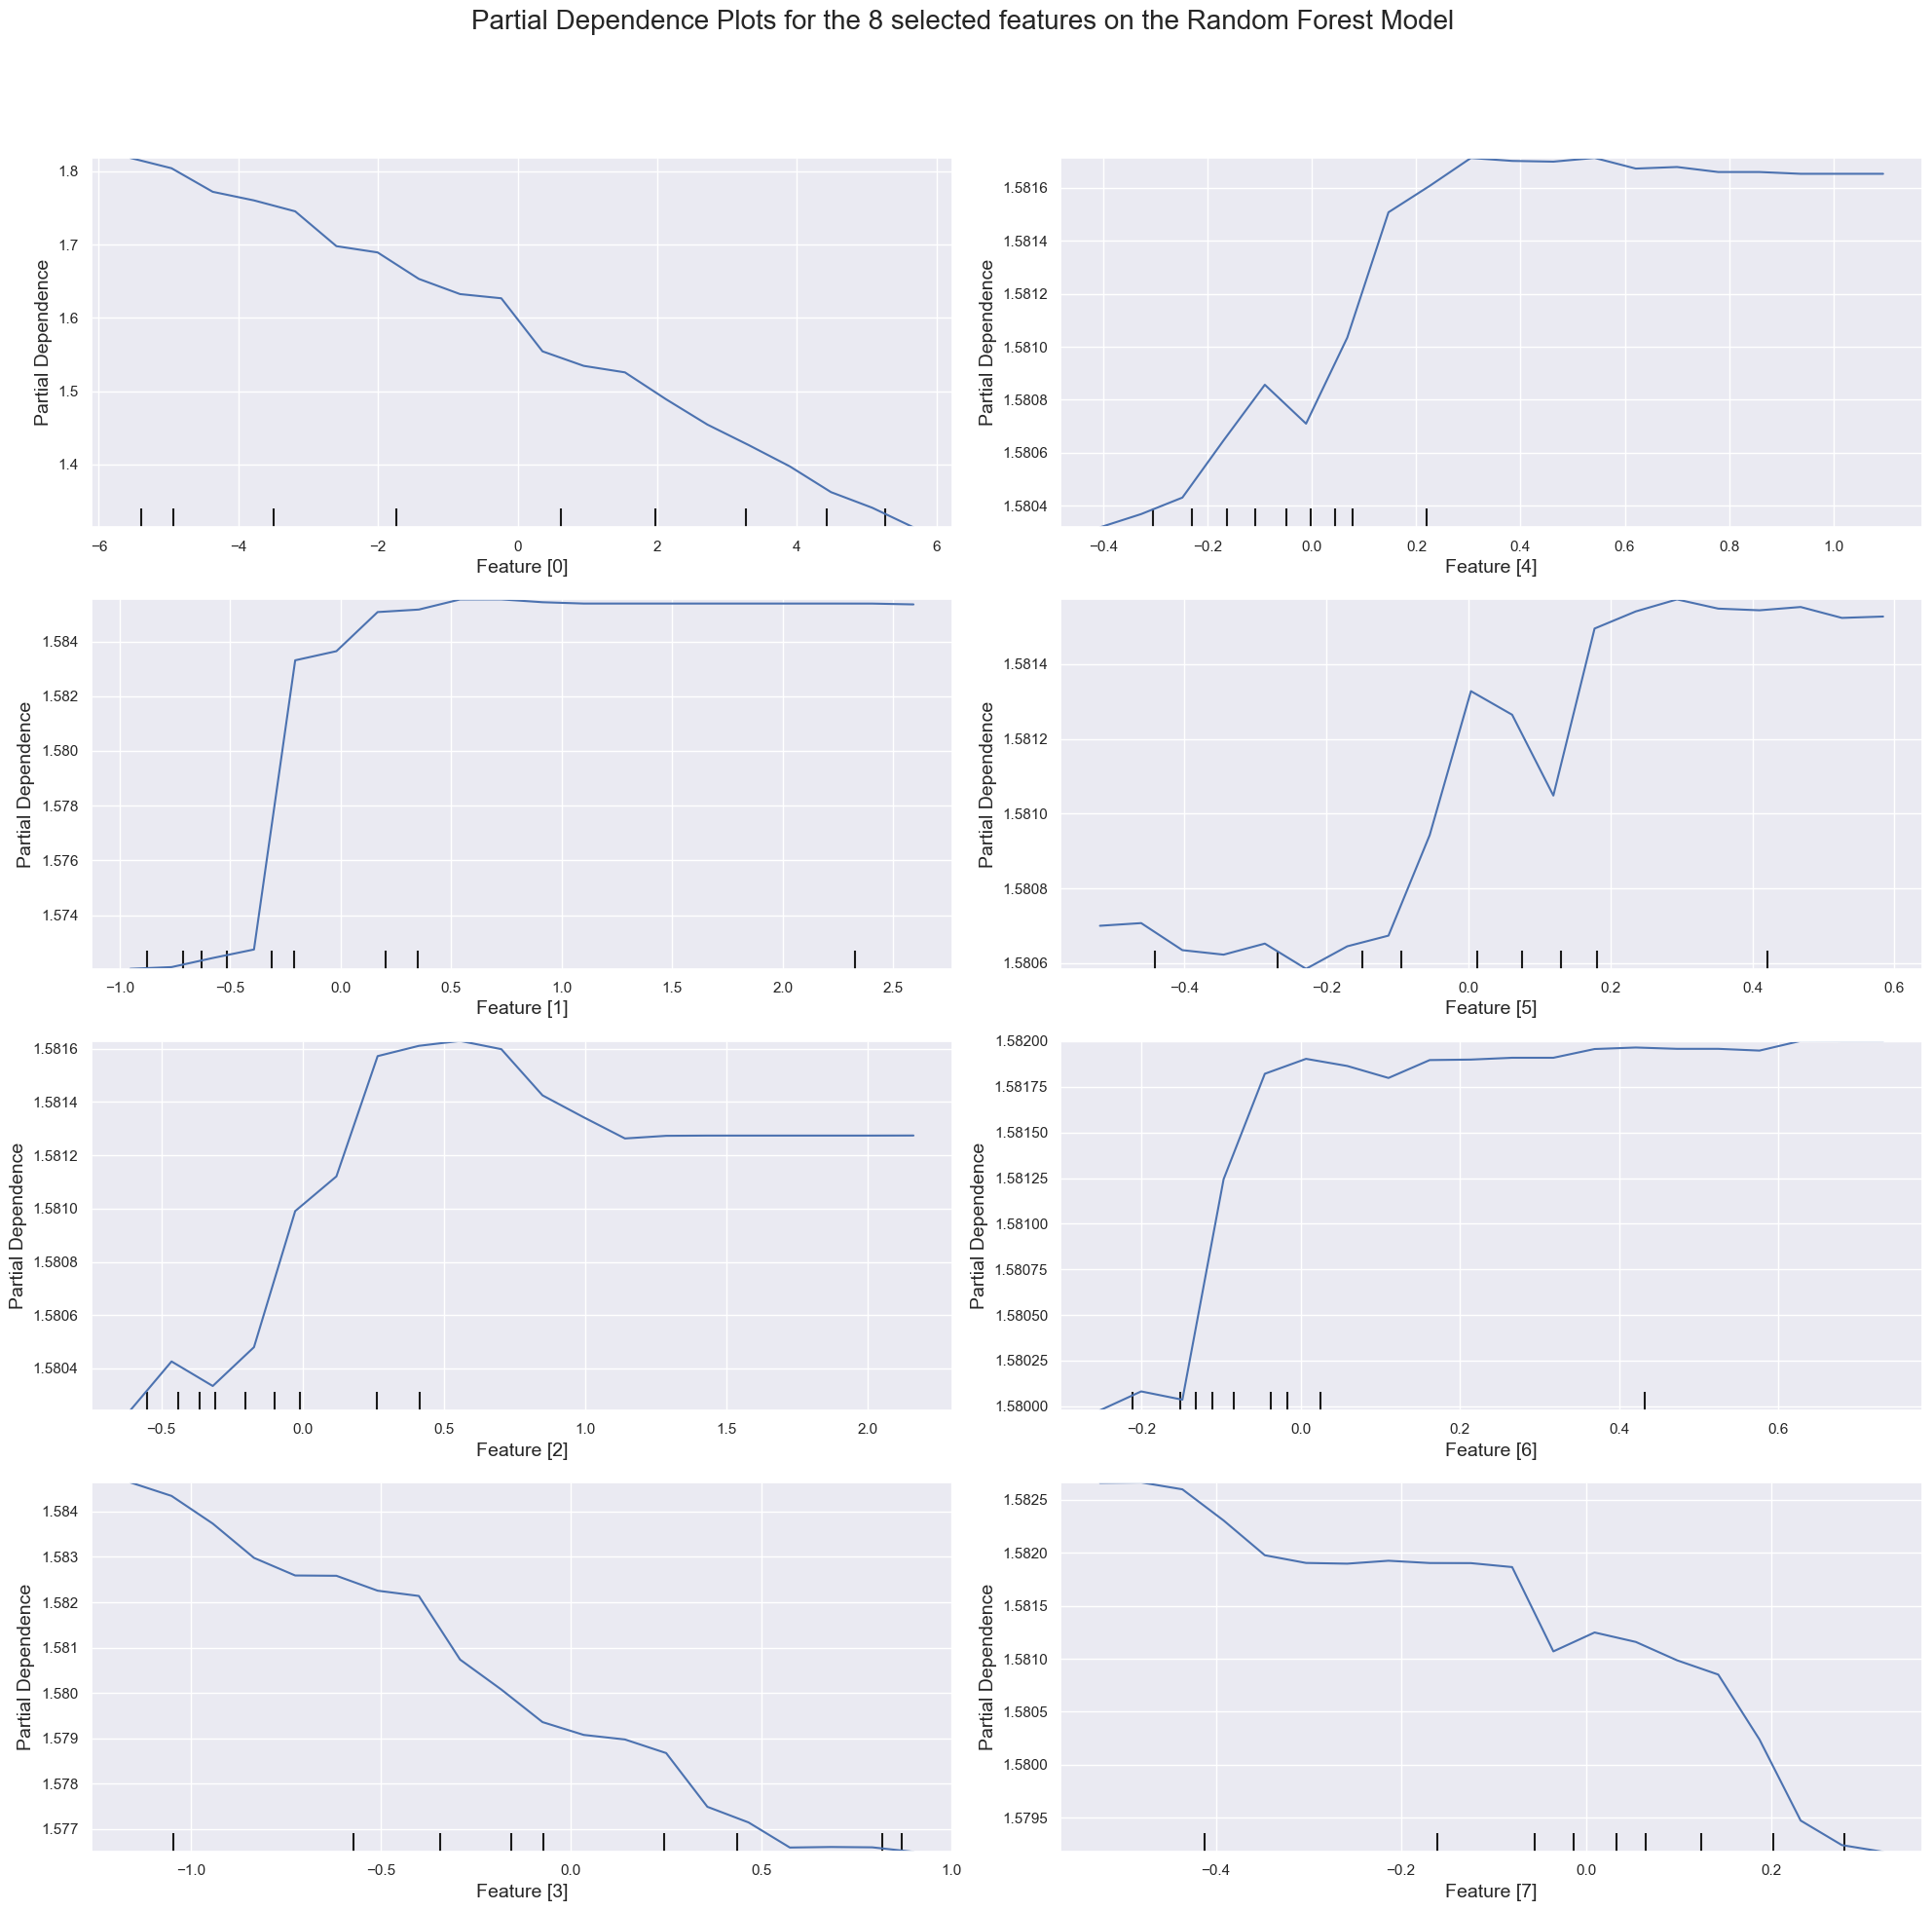

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the Random Forest Model \n", fontsize=20)

for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(regressor, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(regressor, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

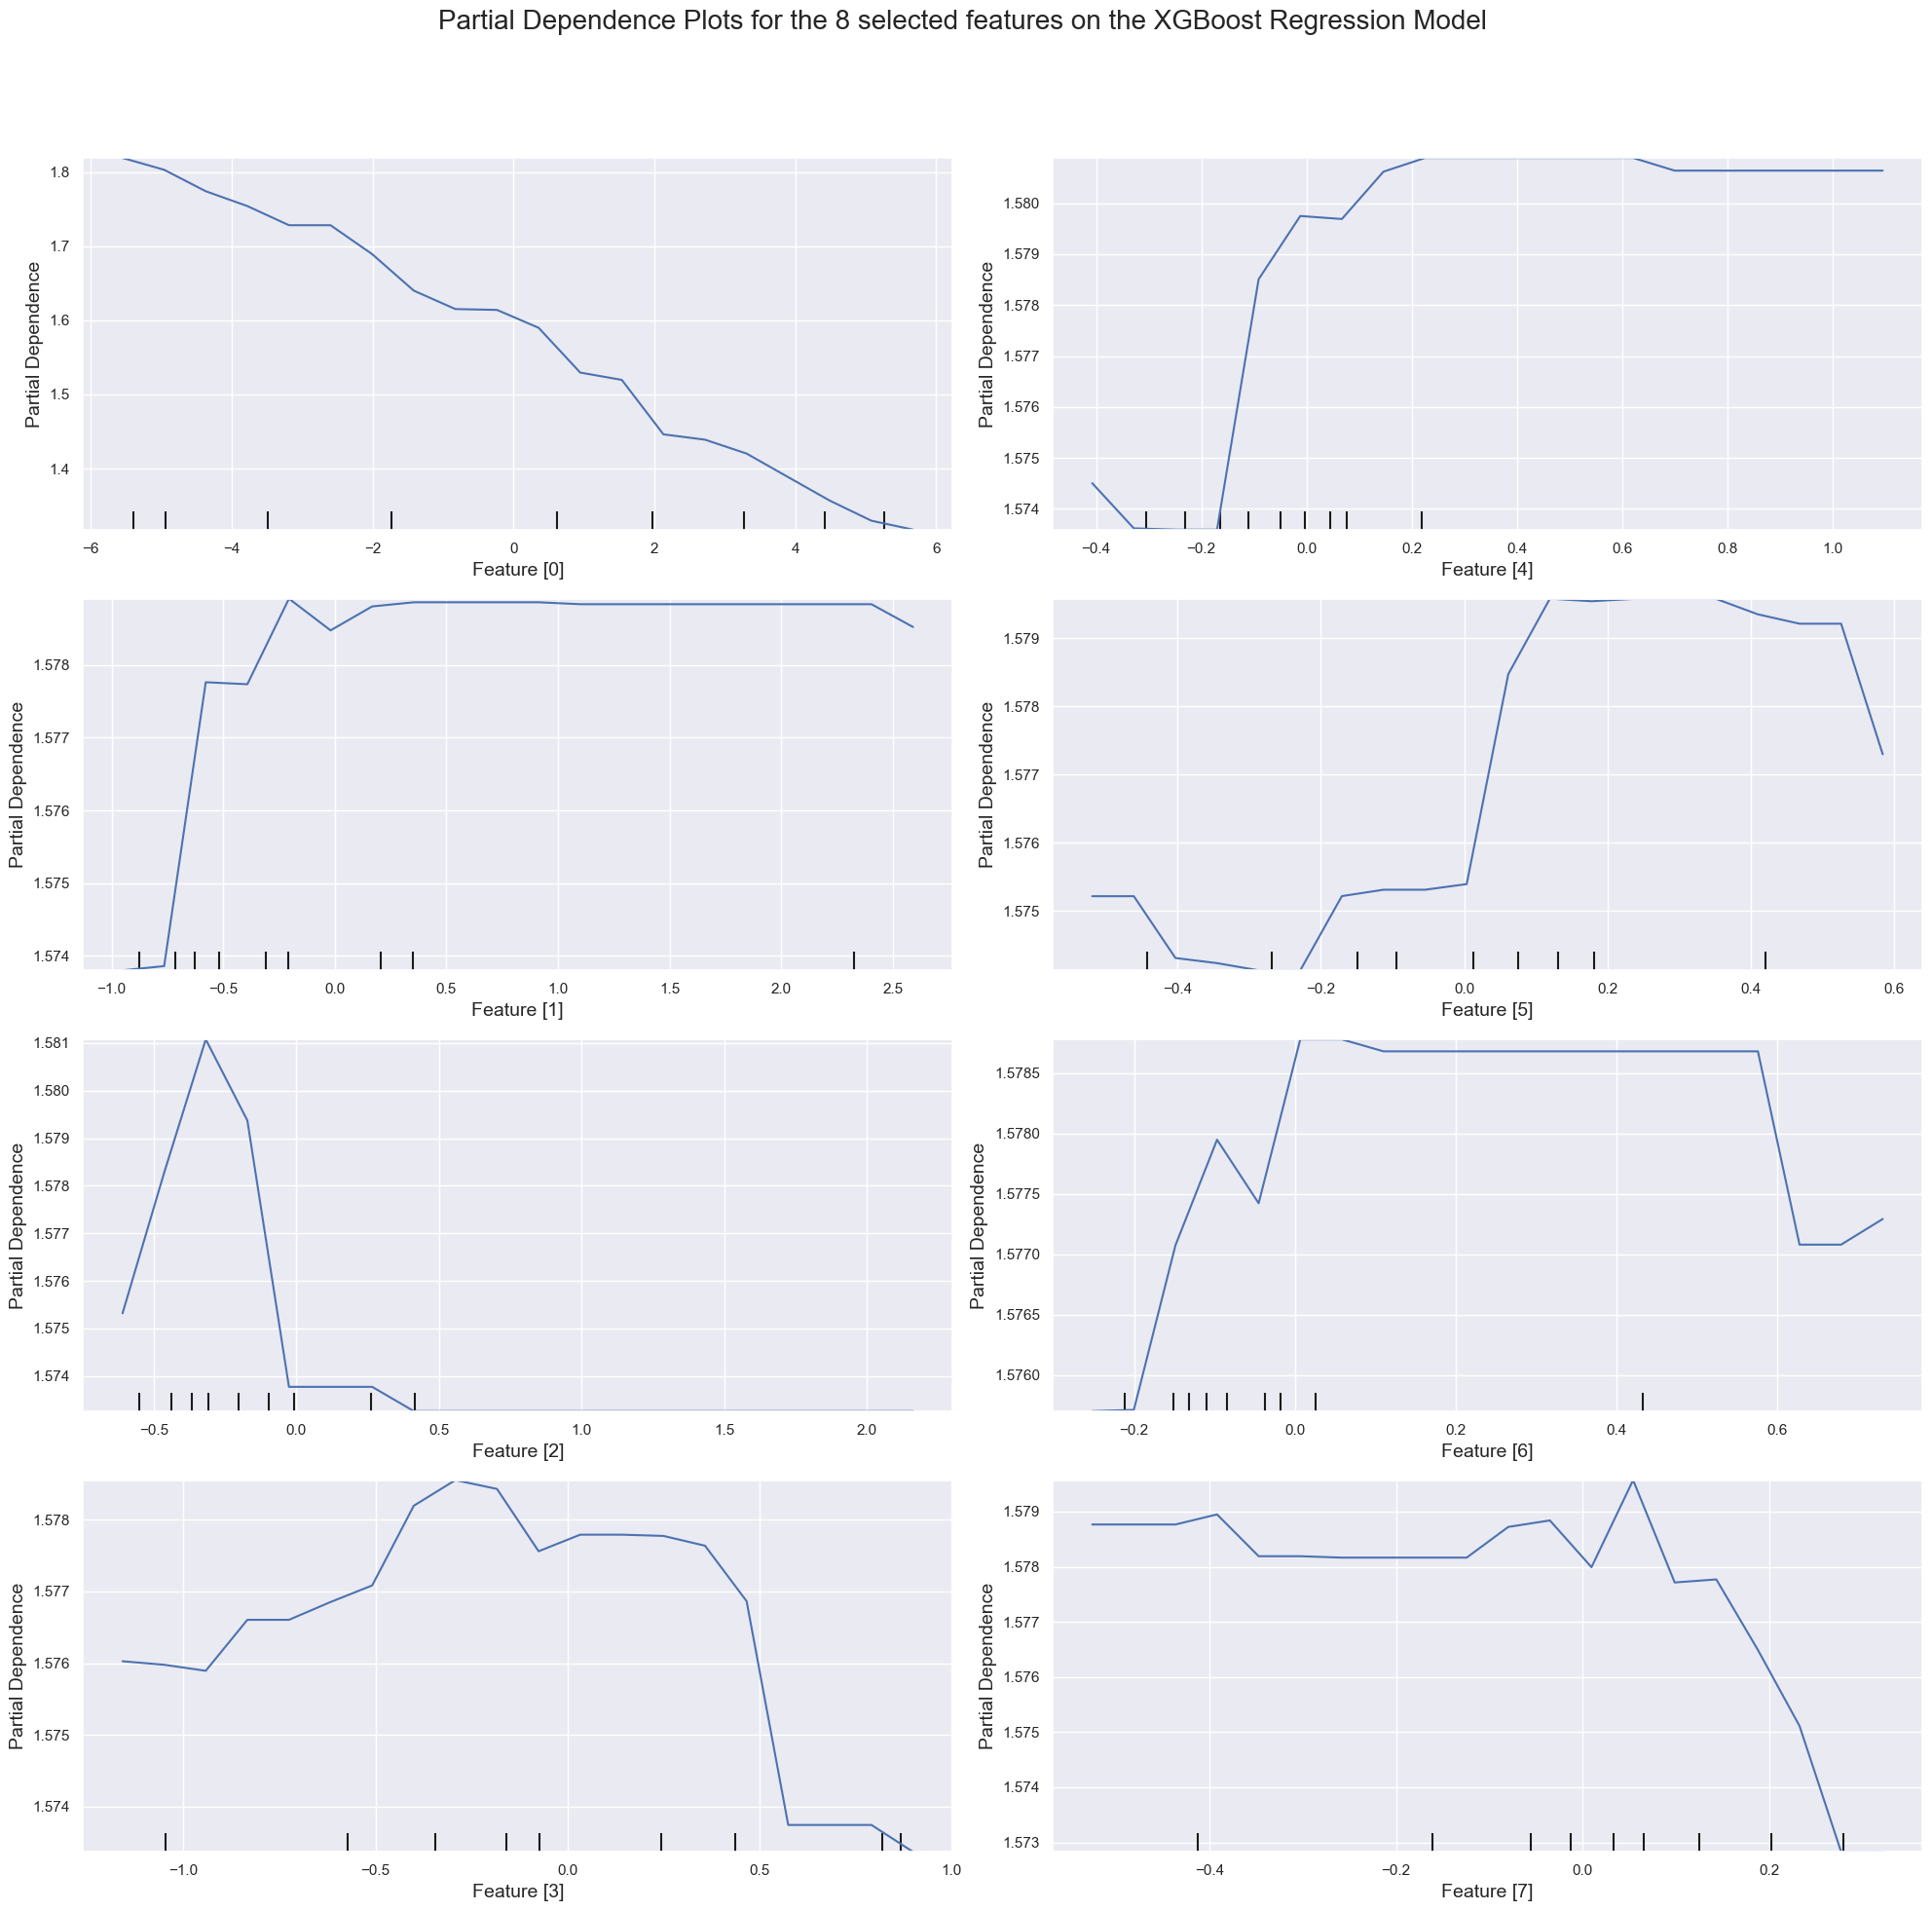

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the XGBoost Regression Model \n", fontsize=20)

xgbr.dummy_ = "dummy"
for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(xgbr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(xgbr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

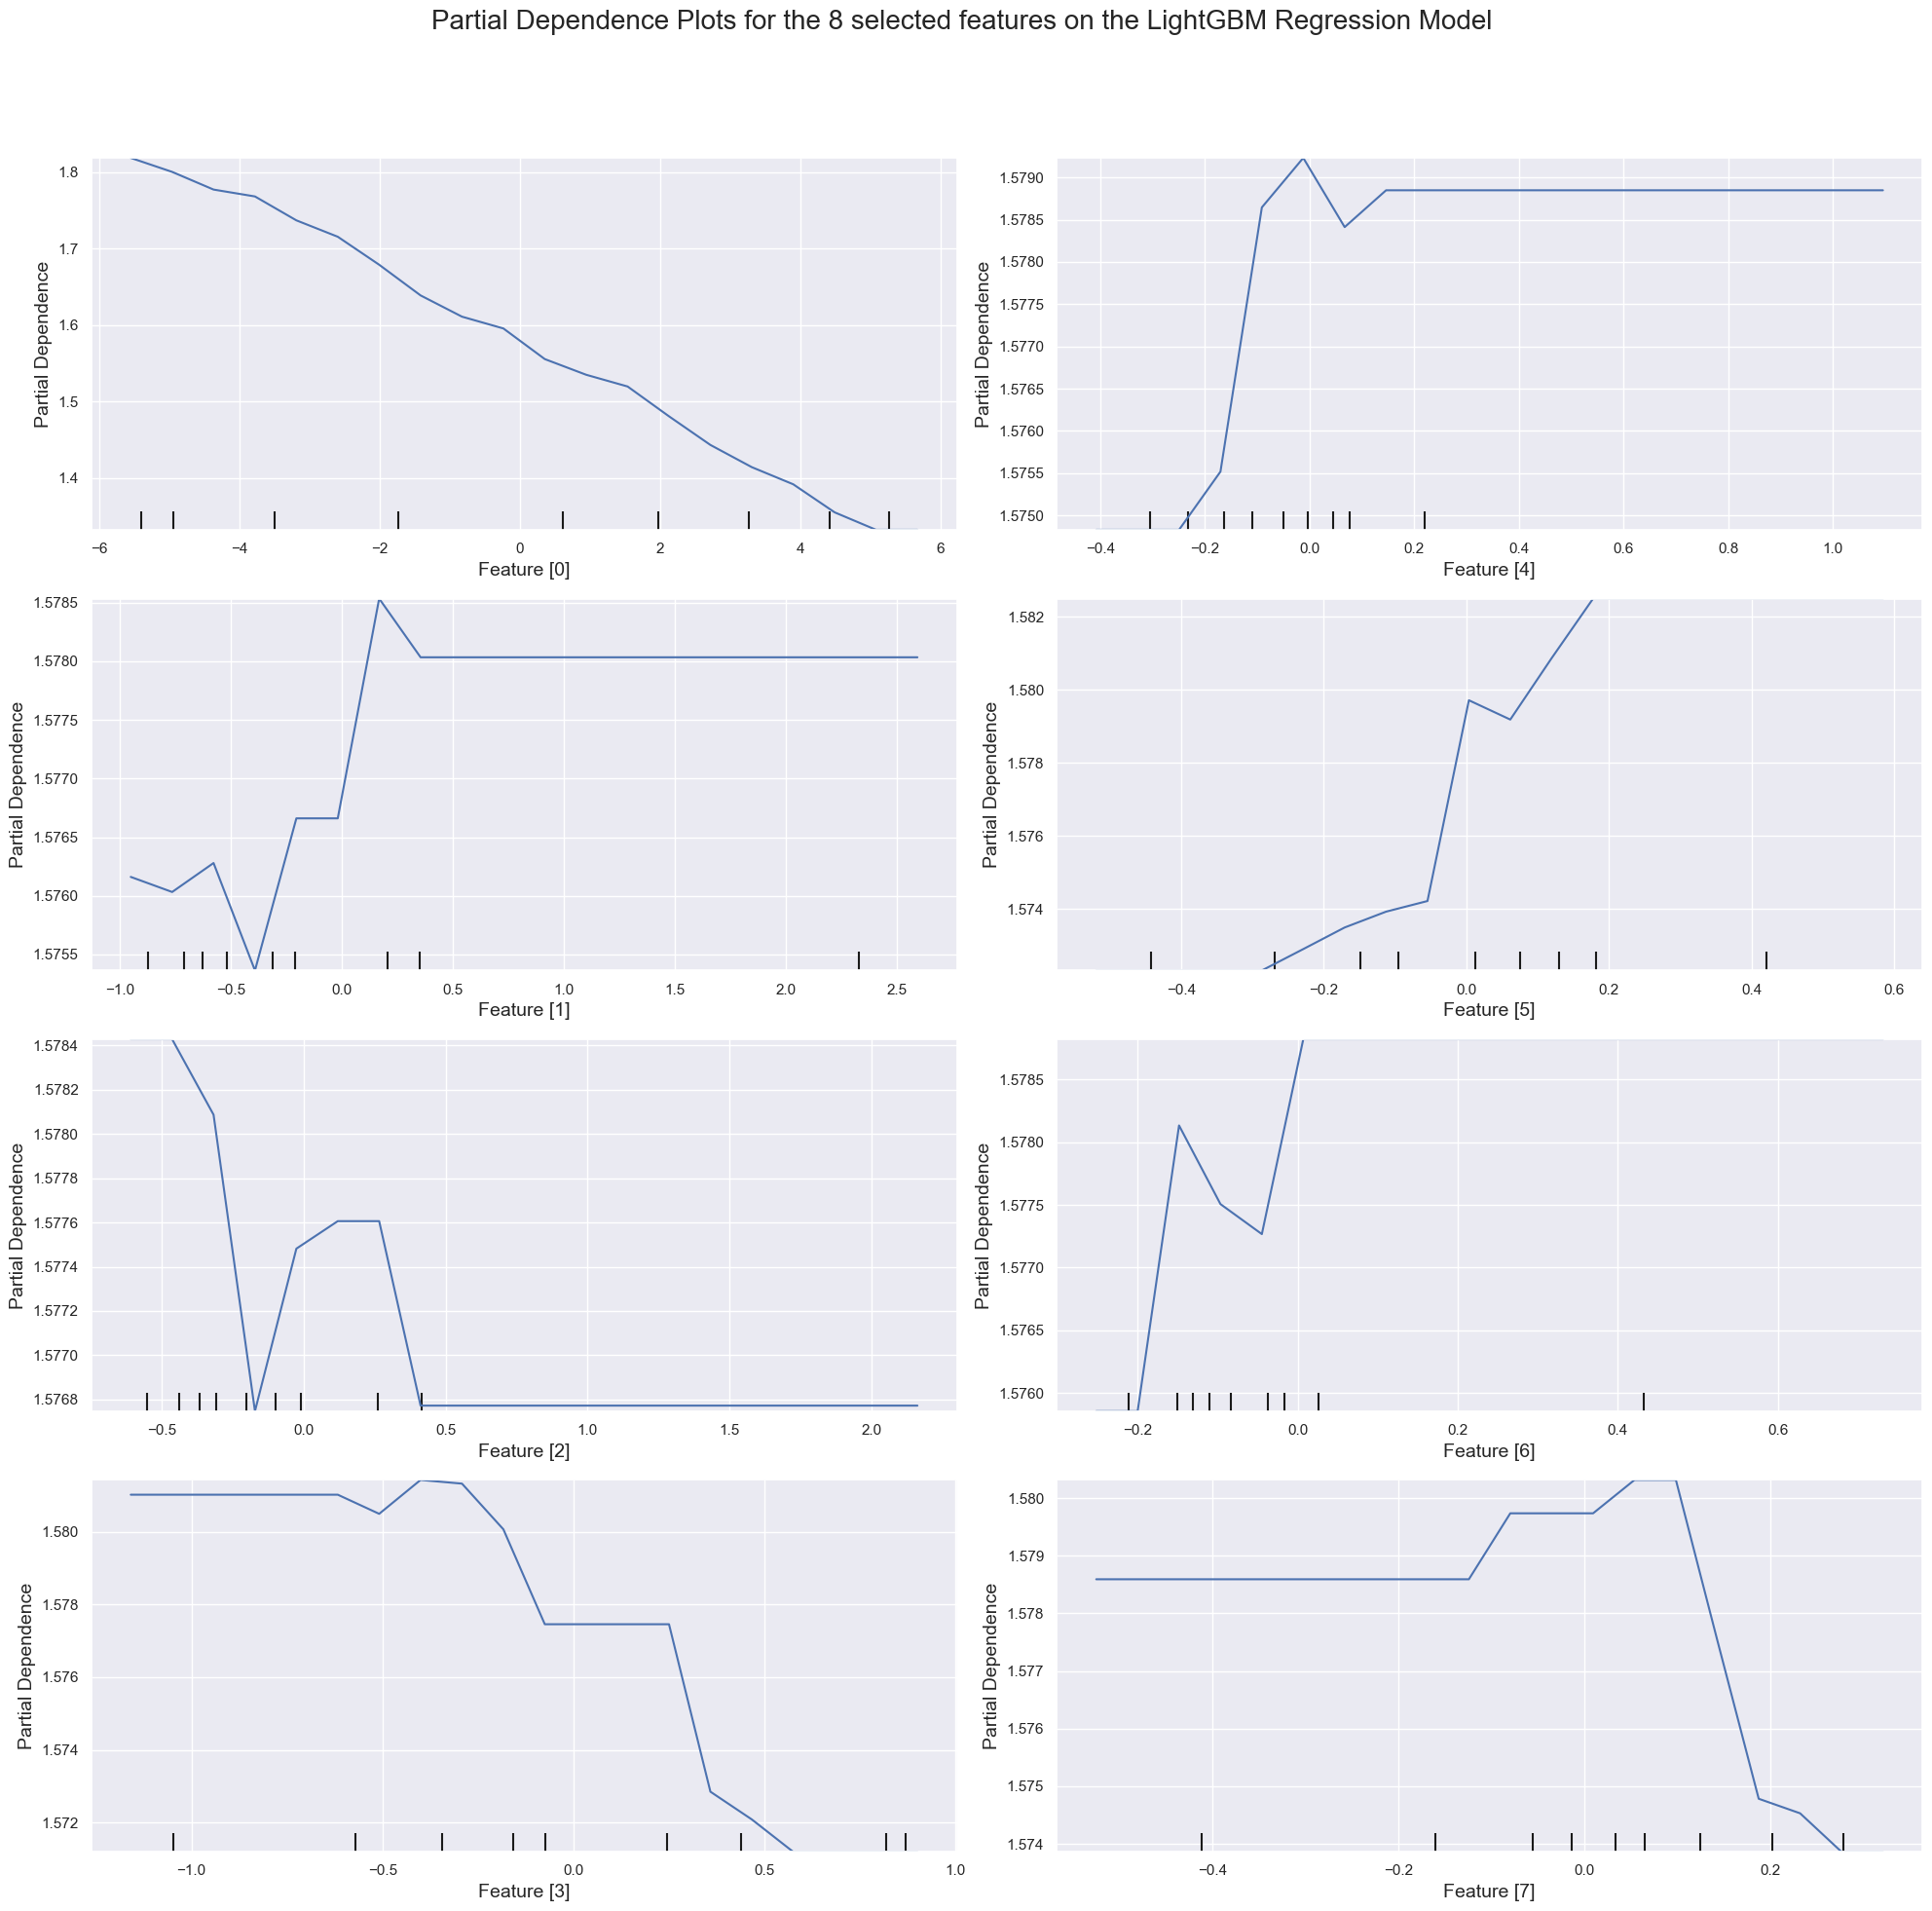

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the LightGBM Regression Model \n", fontsize=20)

lgbmr.dummy_ = "dummy"
for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(lgbmr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(lgbmr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

In [ ]:
x, y = preprocessing(5, 16)     # using cell 5 for training

# Using the original data but not carrying out PCA
train_x1, test_x1, train_y1, test_y1 = train_test_split(x, y, train_size = 0.8)

# Standardize the training data
scaler = StandardScaler()
# Fit the scaler to X_train
scaler.fit(train_x1)

# Transform the entire data using the computed mean and variance
train_x1 = scaler.transform(train_x1)
test_x1 = scaler.transform(test_x1)

In [ ]:
s = SVR()
s.fit(train_x1, train_y1)

print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
print(f"R2 Score = {s.score(test_x1, test_y1):.4f}")

mse = mean_squared_error(s.predict(test_x1), test_y1)
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")

Evaluating the Support Vector Regressor...
R2 Score = 0.9219
RMSE = 0.0505


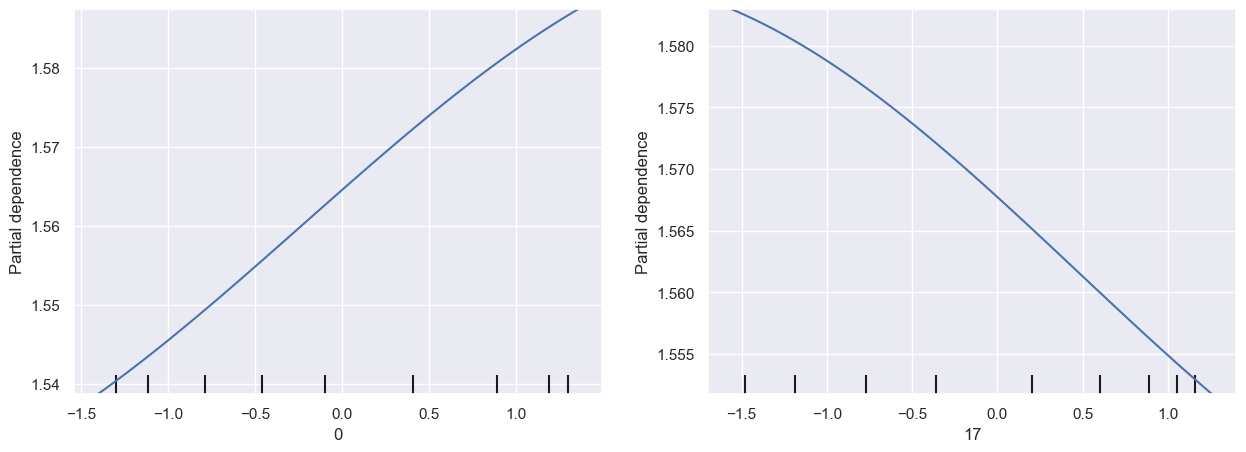

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
# PDP for time at which battery voltage hits 2.7V
disp_s0 = PartialDependenceDisplay.from_estimator(s, train_x1, features=[0], ax=ax1)

# PDP for maximum temperature
disp_s17 = PartialDependenceDisplay.from_estimator(s, train_x1, features=[17], ax=ax2)

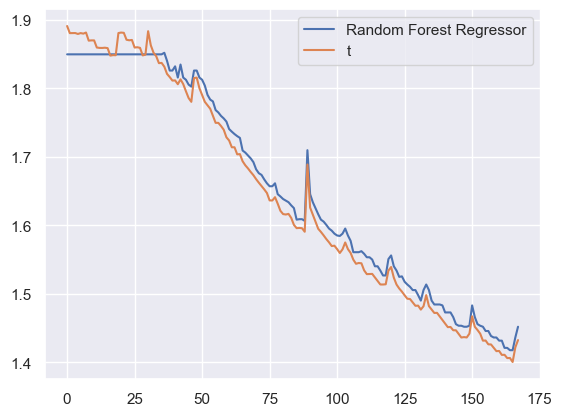

In [ ]:
# Using the pre-built sklearn RF regressor without tuning
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(train_x1[:,0].reshape(-1, 1), train_y1)
''''
print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
print(f"R2 Score = {rf.score(test_x1, test_y1):.4f}")

mse = mean_squared_error(rf.predict(test_x1), test_y1)
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")
'''

x, y = preprocessing(7, 16)
x = scaler.transform(x)
plt.plot(rf.predict(x[:,0].reshape(-1, 1)), label = "Random Forest Regressor")
plt.plot(y, label = "t")
plt.legend()

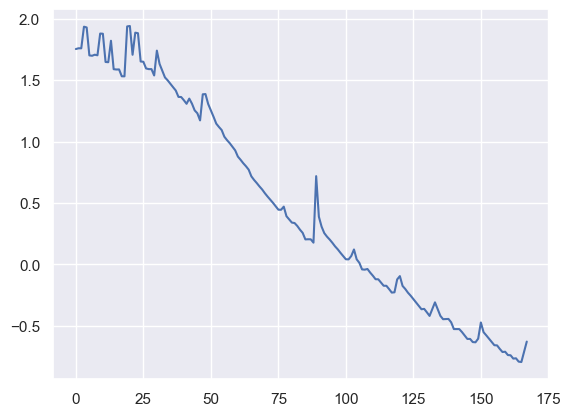

In [ ]:
plt.plot(x[:,0])

In [ ]:
train_y.shape
train_x[:,1].shape

(134,)

d:\Environment\Anaconda\envs\tensorflow38\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:1110: UserWarning: Attempting to set identical bottom == top == 1.5719862310178179 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


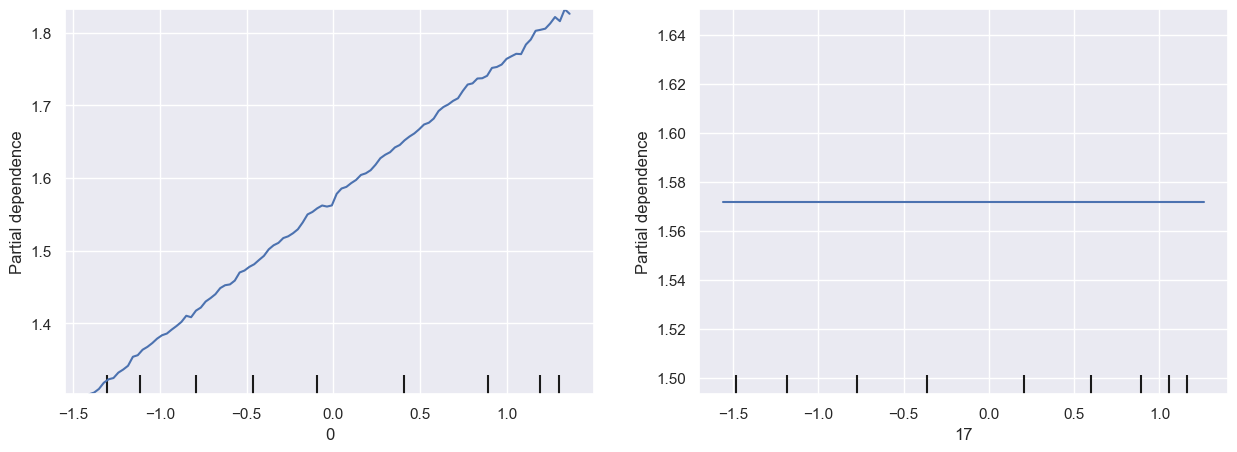

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
# PDP for time at which battery voltage hits 2.7V
disp_rf0 = PartialDependenceDisplay.from_estimator(rf, train_x1, features=[0], ax=ax1)

# PDP for maximum temperature
disp_rf17 = PartialDependenceDisplay.from_estimator(rf, train_x1, features=[17], ax=ax2)